In [1]:
"""Scripts for analyzing of phantom outputs.

This script generate lightcurves (LC) by doing radiative transfer on a grid.


-------------------------------------------------------------------------------

Side note: Remember to limit line length to 79 characters according to PEP-8
    https://peps.python.org/pep-0008/#maximum-line-length    
which is the length of below line of '-' characters.

-------------------------------------------------------------------------------

"""

"Scripts for analyzing of phantom outputs.\n\nThis script generate lightcurves (LC) by doing radiative transfer on a grid.\n\n\n-------------------------------------------------------------------------------\n\nSide note: Remember to limit line length to 79 characters according to PEP-8\n    https://peps.python.org/pep-0008/#maximum-line-length    \nwhich is the length of below line of '-' characters.\n\n-------------------------------------------------------------------------------\n\n"

.

# Def

.

## Imports & Settings

In [2]:
import numpy as np
from numpy import pi
from astropy import units
from astropy import constants as const
import matplotlib.pyplot as plt
from matplotlib.typing import ColorType
import matplotlib as mpl
from numba import jit
import sarracen
import itertools
from scipy import integrate, fft
from scipy.spatial import kdtree
from datetime import datetime
# fix weird moviepy cannot find my ffmpeg exe error
try: from moviepy import editor
except RuntimeError: import os; os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"
from moviepy.editor import ImageSequenceClip, concatenate_videoclips
import gc
#from os import path

In [3]:
# import my modules listed in ./main/

import clmuphantomlib as mupl
from clmuphantomlib            import MyPhantomDataFrames, get_eos
from clmuphantomlib.log        import is_verbose, say
from clmuphantomlib.settings   import DEFAULT_SETTINGS as settings
from clmuphantomlib.units_util import get_val_in_unit, set_as_quantity #, get_units_field_name, get_units_cgs
from clmuphantomlib.io         import json_dump, json_load
from clmuphantomlib.eos.mesa   import EoS_MESA_opacity
from clmuphantomlib.light      import get_optical_depth_by_ray_tracing_3D, get_photosphere_on_ray

from multiprocessing import cpu_count, Pool #Process, Queue
NPROCESSES = 1 if cpu_count() is None else max(cpu_count(), 1)

In [4]:
# settings
#
#   imported from script_input.py file


from script_LCGen__input import verbose, verbose_loop, interm_dir, output_dir, unitsOut, SPEC_DIST, PHOTOSPHERE_TAU, JOB_PROFILES_DICT
from _sharedFuncs import mpdf_read

# remove temp flag
interm_dir = interm_dir.split('test_')[0]

unitsOutTxt = {  key  : unitsOut[key].to_string('latex_inline') for key in unitsOut.keys() }

spec_dist = SPEC_DIST

# set metadata
with open("_metadata__input.json", 'r') as f:
    metadata = json_load(f)
metadata['Title'] = "Getting light curves by intergrating across a grid of rays"
metadata['Description'] = f"""Getting light curves by intergrating across a grid of rays with the same directions
for dump file data generated by phantom
"""


plt.rcParams.update({'font.size': 20})
if __name__ == '__main__' and is_verbose(verbose, 'note'):
    # remember to check if name is '__main__' if you wanna say anything
    #    so when you do multiprocessing the program doesn't freak out
    say('note', "script", verbose, f"Will use {NPROCESSES} processes for parallelization")


*   Note   :    script:
	Will use 20 processes for parallelization


In [5]:
from clmuphantomlib.log import say, is_verbose
from clmuphantomlib.geometry import get_dist2_between_2pt, get_closest_pt_on_line
from clmuphantomlib.sph_interp import get_sph_interp, get_h_from_rho, get_no_neigh, _get_sph_interp_phantom_np
from clmuphantomlib.units_util import set_as_quantity, set_as_quantity_temperature, get_units_field_name
from clmuphantomlib.eos   import EoS_Base
from clmuphantomlib.light import integrate_along_ray_grid, integrate_along_ray_gridxy

#  import (general)
import numpy as np
import numba
from numba import jit, prange
import sarracen
from scipy.stats import linregress

from clmuphantomlib.geometry import get_dist2_from_pts_to_line, get_dist2_from_pt_to_line_nb, get_ray_unit_vec, get_rays_unit_vec

## Functions

In [6]:
# load from matin script

# backup-ed old codes
from script_LCGen import integrate_along_ray, integrate_error_along_ray
# test codes (alpha)
from script_LCGen import _integrate_along_ray_gridxy_sub_parallel_analysis_test
# actual code
from script_LCGen import _integrate_along_ray_gridxy_sub_parallel_analysis, _integrate_along_ray_gridxy_sub_parallel_err_ind
# integrations
from script_LCGen import integrate_along_ray_gridxy_ind, integrate_along_ray_gridxy_err_ind
# rays grid generation, plotting
from script_LCGen import get_xy_grids_of_rays, plot_imshow
# error estimation
from script_LCGen import get_sph_neighbours, get_sph_error

In [7]:
def plot_comb(
    comb : dict,
    mode : str,
    output_dir: str,
    job_nicknames: list[str] = None,
    xyzs_list    : list[str] = None,
    plot_title_dict = {},
    outfilename_noext: None|str = None,
    out_savename : None|str = None,
    no_xy_txt    : None|str = None,
    xlim: None|tuple[float, float] = None,
    ylim: None|tuple[float, float] = None,
    whatlog      : str ='loglog',
    out_exts     : list[str] = ['pdf', 'png'],
    xyzs_V_list  : list[str] = ['xyz', 'xzy', 'yzx'],
    txt_ylabel_dict: dict = {
        'LC'  : 'Luminosity',
        'Nres': '$N_\\mathrm{res}$',
        'Rph' : '$R_\\mathrm{{ph}}$',
        'Aph' : '$A_\\mathrm{{ph}}$',
    },
    txt_title_dict: None|dict = {
        'LC'  : 'Light curves',
        'Nres': 'Photospheric Resolution',
        'Rph' : 'Photospheric radius',
        'Aph' : 'Photospheric area',
    },
) -> tuple[mpl.figure.Figure, mpl.axes.Axes, list[str]]:
    """Plot the lightcurve-related stuff from comb (combined data) generated by the script.

    outfilename_noext, out_savename, no_xy_txt: str
        supply either outfilename_noext or both out_savename & no_xy_txt.

    out_exts: str


    Returns: fig, ax, outfilenames
    
    """

    # sanity check
    if mode not in txt_ylabel_dict.keys():
        raise NotImplementedError(f"{mode=} not yet implemented. Acceptable modes: {txt_ylabel_dict.keys()}")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    which_func = {
        'linear'  : ax.plot,
        'plot'    : ax.plot,
        'semilogx': ax.semilogx,
        'semilogy': ax.semilogy,
        'loglog'  : ax.loglog,
    }
    
    _job_nicknames = comb.keys() if job_nicknames is None else job_nicknames
    for job_nickname in _job_nicknames:

        # # calc total volume of photosphere for latering calc-ing Rph
        # if mode in {'Rph'}:
        #     Axyz = [comb[job_nickname][xyzs_V]['areas'].value/pi for xyzs_V in xyzs_V_list]
        #     V_total = np.prod(Axyz, axis=0)**0.5 * comb[job_nickname][xyzs_V_list[0]]['areas'].unit**1.5
        # else:
        #     V_total = None

        _xyzs_list = comb[job_nickname] if xyzs_list is None else xyzs_list
        for i_xyzs, xyzs in enumerate(_xyzs_list):

            color = f'C{i_xyzs}'
            
            x = comb[job_nickname][xyzs]['times']
            y_err = None
            if   mode in {'LC'}:
                y = comb[job_nickname][xyzs]['lums']
                if 'lums_err' in comb[job_nickname][xyzs].keys():
                    say('note', None, verbose, "Adding y error bars..")
                    y_err = (comb[job_nickname][xyzs]['lums_err']).to(y.unit)
            elif mode in {'Nres'}:
                y = comb[job_nickname][xyzs]['N_res']
            elif mode in {'Rph'}:
                # y = V_total / (comb[job_nickname][xyzs]['areas']/pi)
                y = np.sqrt(comb[job_nickname][xyzs]['areas'] / pi)
            elif mode in {'Aph'}:
                y = comb[job_nickname][xyzs]['areas']
            
            which_func[whatlog](x, y, '-', label=f"{job_nickname}, +{xyzs[2]}", color=color)
            if y_err is not None:
                ax.fill_between(x.value, (y - y_err).value, (y + y_err).value, color=color, alpha=0.5)
            
    ax.legend()
    ax.set_xlabel(f"Time / {x.unit.to_string('latex_inline')}")
    # set y label (remove slash if unit is dimensionless)
    ylabel = f"{txt_ylabel_dict[mode]} / {y.unit.to_string('latex_inline')}" if y.unit.to_string() else f"{txt_ylabel_dict[mode]}"
    ax.set_ylabel(f"{ylabel}")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if outfilename_noext is None:
        outfilename_noext = f"{output_dir}{mode}_{out_savename}_{no_xy_txt}"
    elif output_dir is not None:
        outfilename_noext = f"{output_dir}{outfilename_noext}"
    
    # write pdf
    outfilenames = []
    for out_ext in out_exts:
        if out_ext == 'pdf':
            if job_nickname in plot_title_dict.keys():
                ax.set_title(plot_title_dict[job_nickname])
            else:
                ax.set_title('')
            outfilename = f"{outfilename_noext}.{out_ext}"
            fig.savefig(outfilename)
            if is_verbose(verbose, 'note'):
                say('note', None, verbose, f"Fig saved to {outfilename}.")
            outfilenames.append(outfilename)
        else:
            title_txt  = mode if txt_title_dict is None else txt_title_dict[mode]
            title_txt += f" ({no_xy_txt}"
            if len(job_nicknames) == 1 and job_nickname in plot_title_dict.keys():
                title_txt += f", {plot_title_dict[job_nickname]}"
            title_txt += ")"
            ax.set_title(title_txt)
            outfilename = f"{outfilename_noext}.{out_ext}"
            fig.savefig(outfilename)
            if is_verbose(verbose, 'note'):
                say('note', None, verbose, f"Fig saved to {outfilename}.")
            outfilenames.append(outfilename)

    return fig, ax, outfilenames

In [8]:
def plot_heat(
    no_xy: tuple[int, int],
    rays: units.Quantity|np.ndarray,
    data: units.Quantity|np.ndarray,
    fig = None, ax = None, plot_cbar: bool= True,
    job_profile  : dict= None,
    file_index   : int = -1,
    title_suffix : str ="",
    notes        : dict= None,
    data_label   : str ="",
    save_label   : str ="",
    ylabelpad    : None|float = None,
    xyzs         : str|list[str] = 'xyz',
    out_exts     : list[str] = ['pdf', 'png'],
    nlevel       : int = 100,
    levels       : None|list[float] = None,
    ticks        : None|int|list[float] = None,
    cbar_num_fmt : None|type(abs) = None,
    facecolor    : None|ColorType = None,
    text_color   : None|str = None,
    xylim : None|tuple[float, float] = None,
    norm=None,
    cmap=None,
    output_dir:str|None=None,
    verbose = 3,
):
    """Plotting a heatmap (contourf) of 1D data located at rays

    cbar_num_fmt: function
        colorbar label format.
        e.g. lambda x, pos: f"{x:.2e}"
    
    """


    if not isinstance(data, units.Quantity):
        data = set_as_quantity(data, units.dimensionless_unscaled)

    if not isinstance(rays, units.Quantity):
        rays = set_as_quantity(rays, units.dimensionless_unscaled)

    if job_profile is None:
        job_profile = {
            'plot_title_suffix': '',
            'nickname'         : '',
        }

    Xs = rays[:, 0, 0]
    Ys = rays[:, 0, 1]
    rays_val = rays.reshape(*no_xy, *rays.shape[1:]).value
    extent = (
        rays_val[ 0, 0, 0, 0] - (rays_val[ 1, 0, 0, 0] - rays_val[ 0, 0, 0, 0])/2,
        rays_val[-1,-1, 0, 0] + (rays_val[-1,-1, 0, 0] - rays_val[-2,-1, 0, 0])/2,
        rays_val[ 0, 0, 0, 1] - (rays_val[ 0, 1, 0, 1] - rays_val[ 0, 0, 0, 1])/2,
        rays_val[-1,-1, 0, 1] + (rays_val[-1,-1, 0, 1] - rays_val[-1,-2, 0, 1])/2,
    )
    if xylim is None: xylim  = max([abs(it) for it in extent])
    xylims = (-xylim, xylim)
    if   isinstance(norm, mpl.colors.LogNorm):
        levels = np.logspace(np.log10(norm.vmin), np.log10(norm.vmax), nlevel+1)
    elif isinstance(norm, mpl.colors.Normalize):
        levels = np.linspace(norm.vmin, norm.vmax, nlevel+1) if levels is None else levels
        if isinstance(ticks, int):
            ticks  = np.linspace(norm.vmin, norm.vmax, ticks+1)
    else:
        levels = nlevel if levels is None else levels
        

    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    
    #cax = ax.imshow(data.reshape(no_xy).T.value, norm=norm, cmap=cmap, origin='lower', extent=extent)
    if facecolor is None: facecolor = plt.get_cmap(cmap).get_under()
    ax.set_facecolor(facecolor)
    cax = ax.contourf(Xs.reshape(no_xy).value, Ys.reshape(no_xy).value, data.reshape(no_xy).value, levels, norm=norm, cmap=cmap, extend='both')
    for c in cax.collections:
        c.set_edgecolor("face")
    if plot_cbar:
        cbar= fig.colorbar(cax, label=f"{data_label} / {data.unit.to_string('latex_inline')}", ticks=ticks, format=cbar_num_fmt)
    ax.set_xlabel(f"${xyzs[0]}$ / {rays.unit.to_string('latex_inline')}")
    ax.set_ylabel(f"${xyzs[1]}$ / {rays.unit.to_string('latex_inline')}", labelpad=ylabelpad)
    ax.set_xlim(xylims)
    ax.set_ylim(xylims)
    ax.set_title('')
    if notes is not None:
        ax.text(
            0.98, 0.98,
            f"Time = {notes['time']:.1f}\n",
            # + f" $L$ = {notes['lum' ]:.0f}",
            color = text_color,
            ha = 'right', va = 'top',
            transform=ax.transAxes,
        )

    no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
    outfilename_noext = f"{output_dir}heat_{job_profile['nickname']}_{file_index:05d}_{''.join(xyzs)}_{save_label}_{no_xy_txt}"
    outfilenames = []

    # write pdf
    for out_ext in out_exts:
        outfilename = f"{outfilename_noext}.{out_ext}"
        if out_ext == 'pdf':
            ax.set_title('')
        else:
            ax.set_title(f"Heatmap of {data_label}\n{job_profile['plot_title_suffix']}")
        fig.savefig(outfilename)
        outfilenames.append(outfilename)
        if is_verbose(verbose, 'note'):
            say('note', None, verbose, f"Fig saved to {outfilename}.")
        
    return fig, cax, outfilenames

## example
#fig, ax = plot_imshow(
#    no_xy, rays * units.Rsun, anses, data_label="$I$", save_label="I_xyz",
#    job_profile=job_profile, file_index=file_index, output_dir=output_dir)

## Main

In [14]:
# settings
output_dir = f'../fig/20240222_LCGen/'
job_nicknames = ['2md'] #['2m_2022'] #['2md'] #['4md'] #
def get_out_savename(job_nicknames):
    if job_nicknames is None:    return None
    elif len(job_nicknames) > 1: return 'dusty'
    else:                        return  job_nicknames[0]
out_savename = get_out_savename(job_nicknames)
xyzs_list = None #['xyz', 'xzy'] #None

unit_I = units.erg/units.cm**2/units.s/units.rad**2

do_plots = {
    'LC'  : {
        'do_this': True,
        'xlim'   : ( 0., 45.),
        'ylim'   : (1e4, 1e7),
        'whatlog': 'semilogy',
        },
    'Nres': {
        'do_this': True,
        'xlim'   : ( 0., 45.),
        'ylim'   : (1.0, 100.),
        'whatlog': 'semilogy',
        },
    'Rph' : {
        'do_this': True,
        'xlim'   : ( 0., 20.), # ( 0., 45.), # 
        'ylim'   : ( 0., 300.), # ( 0., 700.), # (1e0, 1e3),
        'whatlog': 'plot', #'semilogy',
        },
    'Aph' : {
        'do_this': True,
        'xlim'   : ( 0., 20.),
        'ylim'   : ( 0., 3e5), # (1e1, 1e6),
        'whatlog': 'plot', #'semilogy',
        },
}
plot_title_dict = {
    '2md': '$1.7 M_\\odot$',
    '4md': '$3.7 M_\\odot$',
}

In [15]:
# patching

# JOB_PROFILES_DICT['2md']['file_indexes'] = JOB_PROFILES_DICT['2md']['file_indexes'][JOB_PROFILES_DICT['2md']['file_indexes']<=17250]

# additional_interm_files = []
additional_interm_files = [
    (f"{interm_dir}lcgen.256x256.4md.json", "256x256", "4md"),
    (f"{interm_dir}lcgen.256x256.2md.hdf5", "256x256", "2md"),
]

In [16]:
# read data ( existing intermediate files (summary))
if __name__ == '__main__':
    combs = {}
    plt.close('all')
    
    for rays_res in [256]:#[16, 64, 256]: #[16, 32, 64, 128, 256]:
        no_xy = (rays_res, rays_res)
        no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
        filepath = f"{interm_dir}lcgen.{no_xy_txt}.hdf5" # .hdf5
        print(f"Reading from '{filepath}'...", end=' ')
        #combs[no_xy_txt] = mupl.hdf5_load(filepath)
        if filepath[-5:] == '.json':
            with open(filepath, 'r') as f:
                combs[no_xy_txt] = mupl.json_load(f)
        elif filepath[-5:] == '.hdf5':
            combs[no_xy_txt] = mupl.hdf5_load(filepath)
        print("Done.")

    for filepath, no_xy_txt, job_nickname in additional_interm_files:
        print(f"Reading from '{filepath}'...", end=' ')
        if filepath[-5:] == '.json':
            with open(filepath, 'r') as f:
                temp_dict = mupl.json_load(f)
        elif filepath[-5:] == '.hdf5':
            temp_dict = {job_nickname: mupl.hdf5_load(filepath)}
        for k in temp_dict.keys():
            if k != '_meta_':    # safety checks
                if k in combs[no_xy_txt].keys():
                    print(f"\n\t*** WARNING: Overwriting {k} data using {filepath} ***")
                combs[no_xy_txt][k] = temp_dict[k]
        print("Done.")

Reading from '../interm/lcgen.256x256.hdf5'... *   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/lcgen.256x256.hdf5  (compress=False)
Done.
Reading from '../interm/lcgen.256x256.4md.json'... Done.
Reading from '../interm/lcgen.256x256.2md.hdf5'... *   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/lcgen.256x256.2md.hdf5  (compress=False)

	*** WARNING: Overwriting 2md data using ../interm/lcgen.256x256.2md.hdf5 ***
Done.


In [17]:
# patching data from individual files
patching_combs = False
if __name__ == '__main__' and patching_combs:
    rays_res = 256
    xyzs_list = ['xyz', 'xzy', 'yzx']
    no_xy = (rays_res, rays_res)
    no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
    
    for job_nickname in ['2md']: #job_nicknames:
        data = {}
        job_profile = JOB_PROFILES_DICT[job_nickname]
        job_name    = job_profile['job_name']
        file_indexes= job_profile['file_indexes']

        # init
        combs[no_xy_txt][job_nickname] = {
            xyzs: {
                'times': np.full(len(file_indexes), np.nan) * units.yr,
                'lums' : np.full(len(file_indexes), np.nan) * units.Lsun,
                'lums_err': np.full(len(file_indexes), np.nan) * units.Lsun,
                'areas': np.full(len(file_indexes), np.nan) * units.au**2,
                # no of particles at the photosphere - lower bound (weighted average per pixel, weighted by lums contribution)
                # i.e. how resolved the photosphere is
                'N_res': np.full(len(file_indexes), -1) * units.dimensionless_unscaled,
                'wavlens': None,
                'L_wavs': None, #np.full((len(file_indexes), len(wavlens)), np.nan) * (units.Lsun/units.angstrom),
                '_meta_': {
                    'lums' : { 'Description': "Luminosity.", },
                    'areas': { 'Description': (
                        "Visible size of the simulated object." +
                        "(i.e. pixel * (area per pixel) * (tau if tau<1 else 1)"), },
                    'N_res': { 'Description': (
                            "no of particles at the photosphere - lower bound" +
                            "(weighted average per pixel, weighted by lums contribution per pixel)"), },
                },
            } for xyzs in xyzs_list
        }
        ifile, file_index = 0, file_indexes[0]
        data_full = mupl.hdf5_load(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{no_xy_txt}.hdf5")
        for xyzs in xyzs_list:
            comb = combs[no_xy_txt][job_nickname][xyzs]
            data = data_full[xyzs]
            comb['wavlens'] = data['wavlens']
            comb['L_wavs'] = np.full((len(file_indexes), len(data['wavlens'])), np.nan) * (units.Lsun/units.angstrom)
            

        for ifile, file_index in enumerate(file_indexes):
            data_full = mupl.hdf5_load(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{no_xy_txt}.hdf5")
            xyzs_list = list(data_full.keys()).copy() if xyzs_list is None else xyzs_list

            for xyzs in xyzs_list:
                comb = combs[no_xy_txt][job_nickname][xyzs]
                data = data_full[xyzs]
                comb['times'][ifile] = data['time']
                comb['lums' ][ifile] = data['lum']
                comb['lums_err'][ifile] = data['lum_err']
                comb['areas'][ifile] = data['area_one']
                comb['N_res'][ifile] = data['N_res']
                comb['L_wavs'][ifile] = data['L_wavs']

        # save
        if False:
            # safety
            assert job_nickname=='2md' and no_xy_txt=='256x256'
            filepath=f"{interm_dir}lcgen.{no_xy_txt}.{job_nickname}.hdf5"
            print(f"\n\t*** WARNING: Overwriting {filepath} data ***")
            mupl.hdf5_dump(combs[no_xy_txt][job_nickname], filepath)
    

In [18]:
combs['256x256'].keys()

dict_keys(['2m_2022', '2md', '4m', '4md'])

### Plotting existing intermediate files (summary)

*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Adding y error bars..
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Adding y error bars..
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Adding y error bars..
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig saved to ../fig/20240222_LCGen/LC_4m_256x256.pdf.
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig saved to ../fig/20240222_LCGen/LC_4m_256x256.png.
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig saved to ../fig/20240222_LCGen/Nres_4m_256x256.pdf.
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig saved to ../fig/20240222_LCGen/Nres_4m_256x256.png.
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig saved to ../fig/20240222_LCGen/Rph_4m_256x256.pdf.
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig saved to ../fig/20240222_LCGen/Rph_4m_256x256.png.
*   Note   :    run_code() ==> <module>() ==> plot_comb():
	Fig 

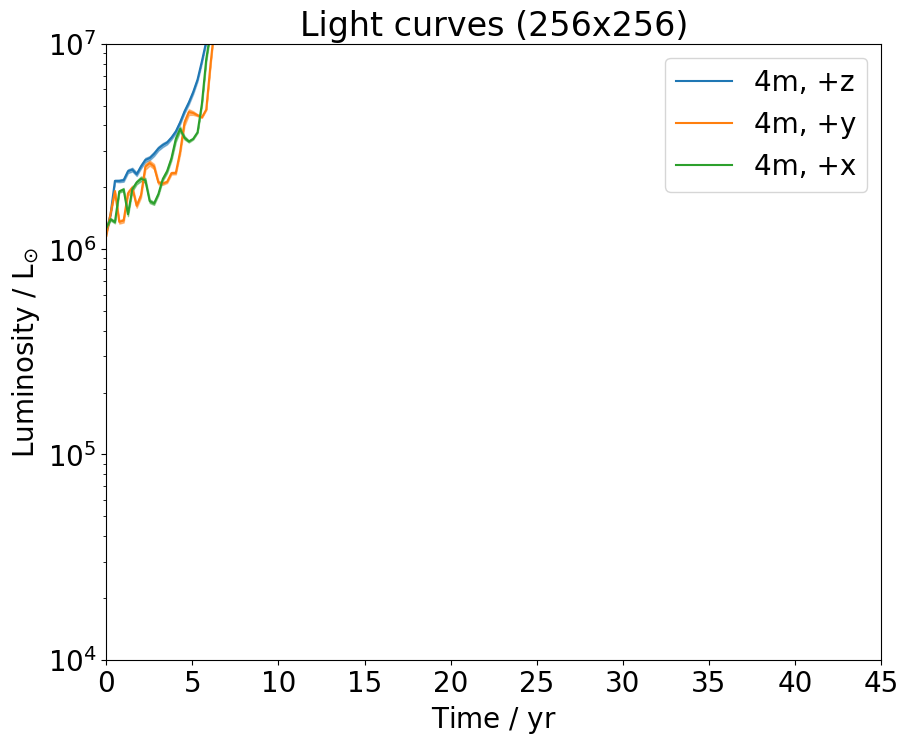

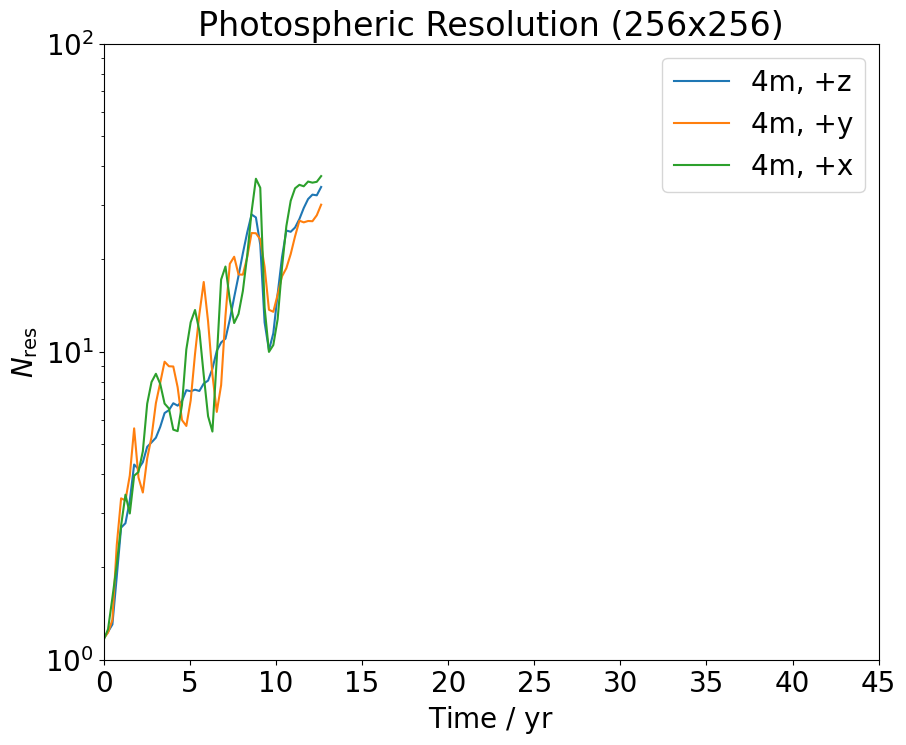

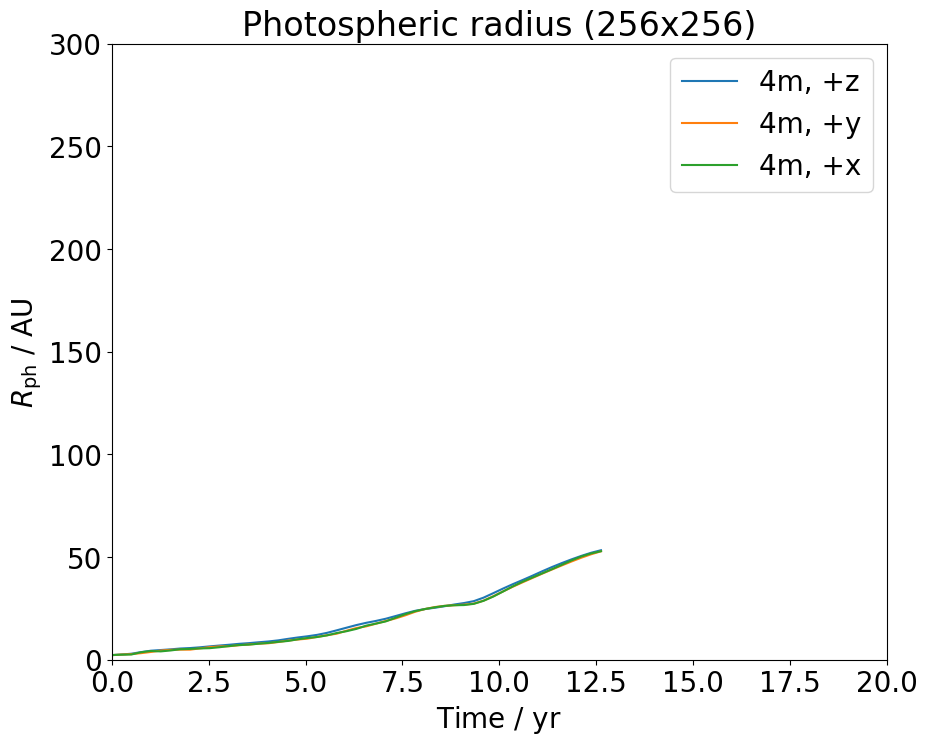

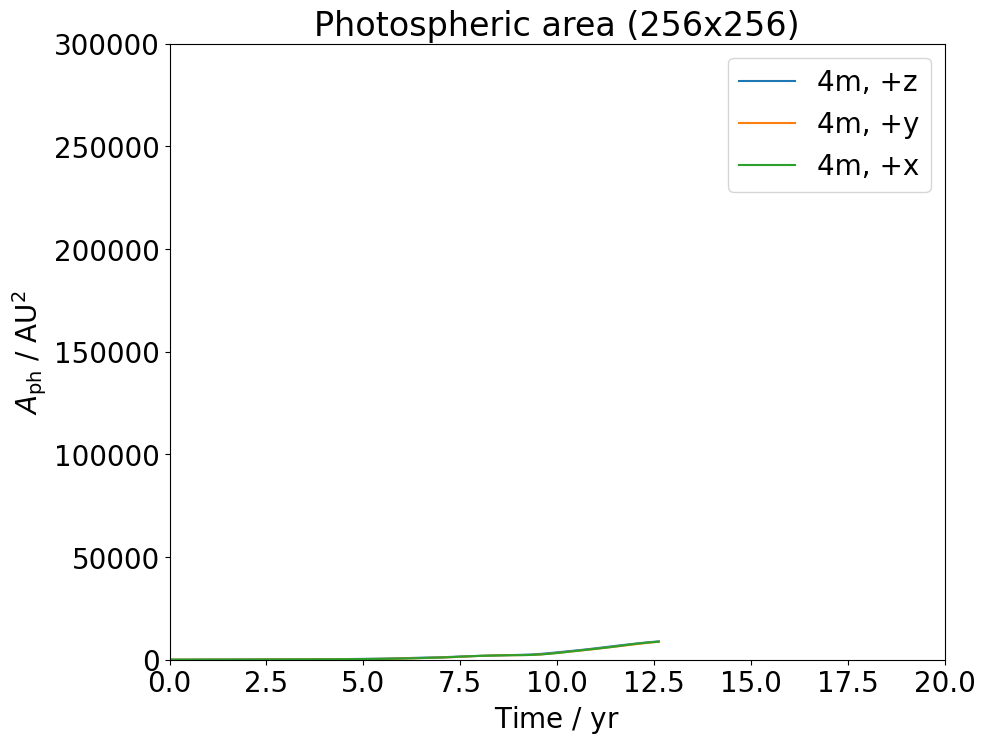

In [34]:
# plot

if __name__ == '__main__':
    figs = []
    for no_xy_txt in combs.keys():
        comb = combs[no_xy_txt]

        for fig in figs:
            fig.clear()
            plt.close(fig)
        figs = []
        for mode in do_plots.keys():
            if do_plots[mode]['do_this']:
                fig, ax, outfilenames = plot_comb(
                    comb, mode, output_dir,
                    job_nicknames=job_nicknames,
                    xyzs_list=xyzs_list,
                    plot_title_dict=plot_title_dict,
                    out_savename=out_savename,
                    no_xy_txt=no_xy_txt,
                    xlim = do_plots[mode]['xlim'],
                    ylim = do_plots[mode]['ylim'],
                    whatlog = do_plots[mode]['whatlog'],
                )
                figs.append(fig)

In [35]:
# fitting photosphere expansion velocity
if __name__ == '__main__':
    for job_nickname, data0 in combs[no_xy_txt].items():
        if job_nickname == '_meta_': continue
        for xyzs, data in data0.items():
            Rph   = (data['areas']/pi)**0.5
            times =  data['times']
            nstop = np.where(times > 10 * units.yr)[0][0]
            ans = linregress(times[nstop:], Rph[nstop:])
            print(
                job_nickname, xyzs, nstop,
                np.polyfit(np.log10(times.value)[nstop:], np.log10(Rph.value)[nstop:], 1),
                f"r-value={ans.rvalue:.5f}",
                f"v_r={(ans.slope * Rph.unit/times.unit).to(units.km/units.s):.2f}",
                f"+/- {(ans.stderr * Rph.unit/times.unit).to(units.km/units.s):.2f}",
            )

2m_2022 xyz 40 [0.54096687 1.0133968 ] r-value=0.91912 v_r=8.41 km / s +/- 0.83 km / s
2m_2022 xzy 40 [0.67259334 0.86962545] r-value=0.96135 v_r=10.35 km / s +/- 0.68 km / s
2m_2022 yzx 40 [0.67662655 0.86490765] r-value=0.96249 v_r=10.40 km / s +/- 0.67 km / s
2md xyz 199 [0.9513365  1.17710787] r-value=0.99979 v_r=57.63 km / s +/- 0.07 km / s
2md xzy 199 [1.00169102 1.08666737] r-value=0.99987 v_r=58.76 km / s +/- 0.05 km / s
2md yzx 199 [0.98266119 1.11365501] r-value=0.99999 v_r=57.37 km / s +/- 0.02 km / s
4m xyz 40 [ 1.95467902 -0.41503653] r-value=0.99765 v_r=35.77 km / s +/- 0.82 km / s
4m xzy 40 [ 2.07080637 -0.54827671] r-value=0.99862 v_r=37.00 km / s +/- 0.65 km / s
4m yzx 40 [ 2.09051494 -0.56653184] r-value=0.99750 v_r=37.50 km / s +/- 0.89 km / s
4md xyz 40 [1.02603344 1.1289895 ] r-value=0.99979 v_r=70.57 km / s +/- 0.13 km / s
4md xzy 40 [1.08460842 1.04763197] r-value=0.99925 v_r=73.82 km / s +/- 0.25 km / s
4md yzx 40 [1.07850618 1.0531384 ] r-value=0.99949 v_r=72.9

### Plotting existing intermediate files (individual dumps)

In [19]:
norm_image = mpl.colors.LogNorm(1e-12, 1e-2, clip=False)

job_nicknames

['2md']

*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00000.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00020.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00040.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00060.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00080.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00100.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00120.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_001

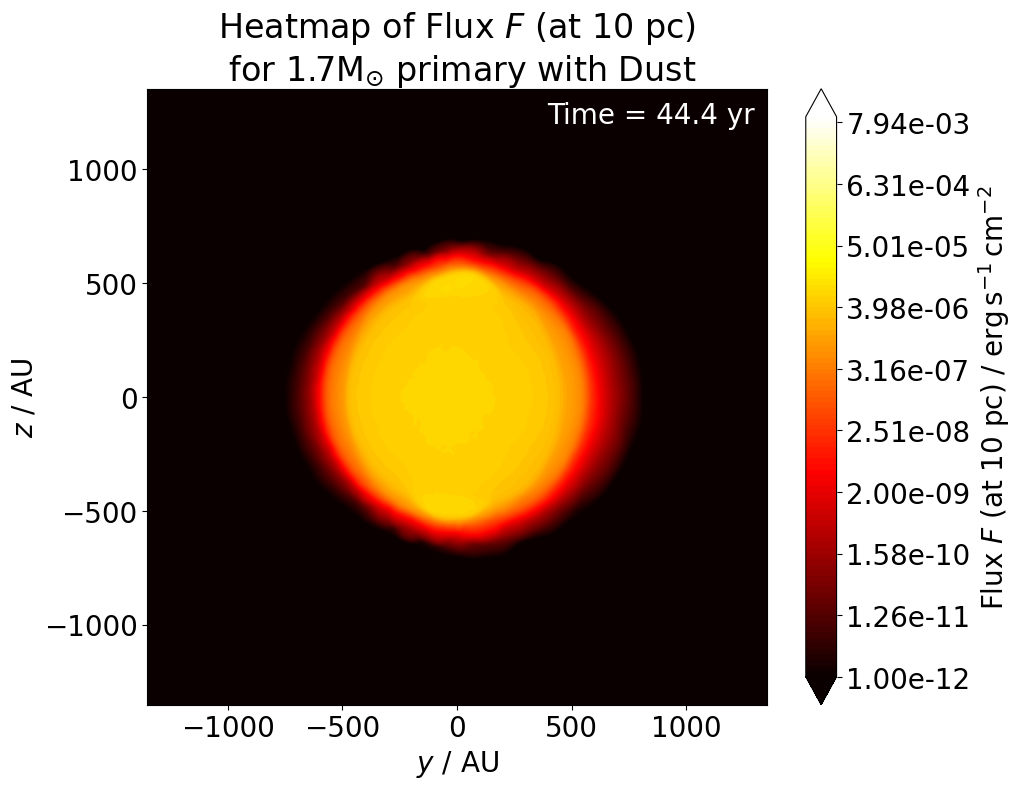

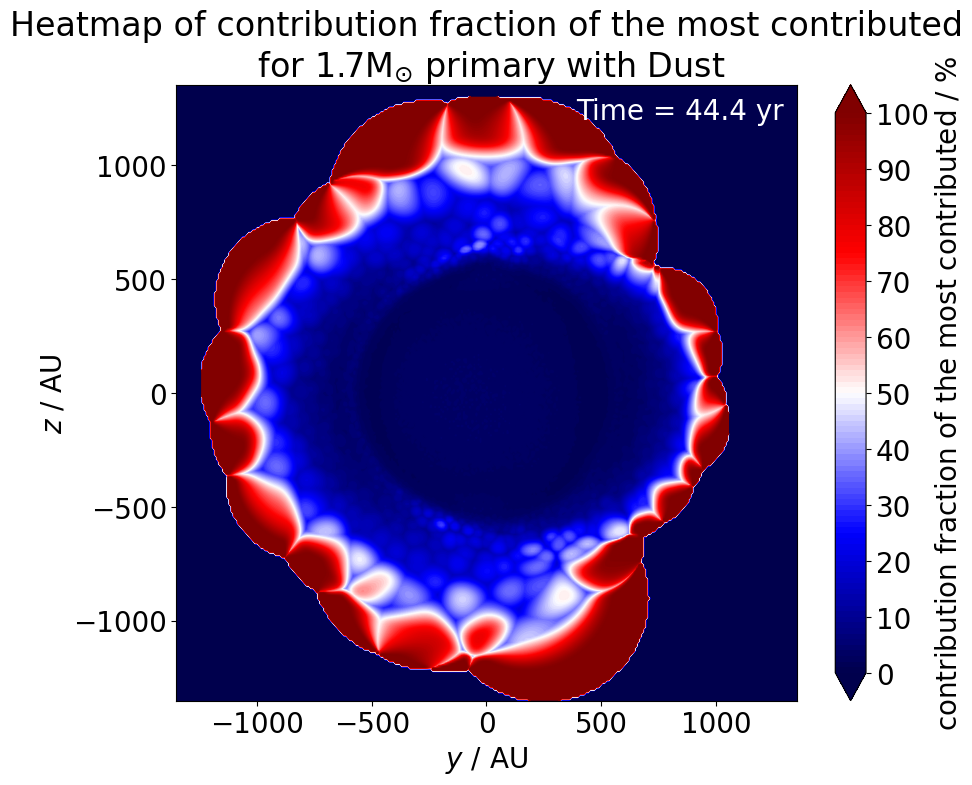

In [20]:
rays_res = 256
no_xy = (rays_res, rays_res)
no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
output_dir = f'../fig/20240222_LCGen/{no_xy_txt}/'

hollywood_mode: bool = False # True


if __name__ == '__main__':

    

    outfilenames_dict = {
        'rads' : {},
        'contr': {},
    }

    figs = []
    for job_nickname in job_nicknames:
        data = {}
        plt.close('all')

        job_profile = JOB_PROFILES_DICT[job_nickname]
        job_name    = job_profile['job_name']
        file_indexes= job_profile['file_indexes']

        for file_index in file_indexes: #[0, 1200, 4800, 8000, 17600]: #
            plt.close('all')
            data_full = mupl.hdf5_load(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{no_xy_txt}.hdf5")
            xyzs_list = list(data_full.keys()).copy() if xyzs_list is None else xyzs_list
            
            # initialize
            for d in outfilenames_dict.keys():
                if job_nickname not in outfilenames_dict[d].keys():
                    outfilenames_dict[d][job_nickname] = {xyzs: [] for xyzs in xyzs_list}

            for xyzs in xyzs_list:
                data = data_full[xyzs]
                # calc flux
                # rads = data['rads'].to(unit_I)
                flux = (data['rads']*data['area_per_ray']*units.rad**2 / spec_dist**2).to(unitsOut['flux'])
                
                # reconstructing rays
                rays_u = np.zeros((data['rays'].shape[0], 2, 3)) * units.au
                rays_u[:, 0, :2] = data['rays']
                rays_u[:, 1, :2] = data['rays']
                rays_u[:, 1] += data['ray_unit_vec'] * units.au

                I_avg = (data['lum']/(4*pi*spec_dist**2)*np.mean(data['area_per_ray']/data['area_one'])).to(unitsOut['flux'])
                I_range = np.min((20., (flux.max()/I_avg).cgs.value,)) * I_avg.value # flux.max().to(unit_I).value #
                

                # plotting

                for fig in figs:
                    fig.clear()
                    plt.close(fig)
                    del fig
                del figs
                figs = []
                
                i_tr = 3560 if job_nickname not in {'2m_2022', '4m', '4md'} else 3500
                xylim_u = 100*units.au if file_index < i_tr else 250*units.au

                # cmap = plt.get_cmap('hot') #; cmap.set_over('white')
                fig, _, outfilenames = plot_heat(
                    no_xy, rays_u, flux,
                    data_label=f"Flux $F$ (at {spec_dist.value:.0f} {spec_dist.unit.to_string('latex_inline')})",
                    xyzs=xyzs, save_label=f"image",
                    job_profile=job_profile, file_index=file_index, cmap='hot', notes=data,
                    norm=norm_image,
                    cbar_num_fmt=lambda x, pos: f"{x:.2e}",
                    text_color='white',
                    xylim=xylim_u.to_value(rays_u.unit) if hollywood_mode else None,
                    output_dir=output_dir, out_exts=['png'], verbose=verbose_loop)
                outfilenames_dict['rads' ][job_nickname][xyzs].append(outfilenames[-1])
                figs.append(fig)

                
                fig, _, outfilenames = plot_heat(
                    no_xy, rays_u, data['contr'], data_label="contribution fraction of the most contributed",
                    xyzs=xyzs, save_label=f"contr",
                    job_profile=job_profile, file_index=file_index, cmap='seismic', notes=data,
                    ticks=10,
                    norm=mpl.colors.Normalize(0., 100.),
                    text_color='white',
                    xylim=xylim_u.to_value(rays_u.unit) if hollywood_mode else None,
                    output_dir=output_dir, out_exts=['png'], verbose=verbose_loop)
                outfilenames_dict['contr'][job_nickname][xyzs].append(outfilenames[-1])
                figs.append(fig)
                # del data, rays_u, rads, I_avg, I_range
            del data_full
            gc.collect()

*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_03500.lcgen.256x256.hdf5  (compress=False)


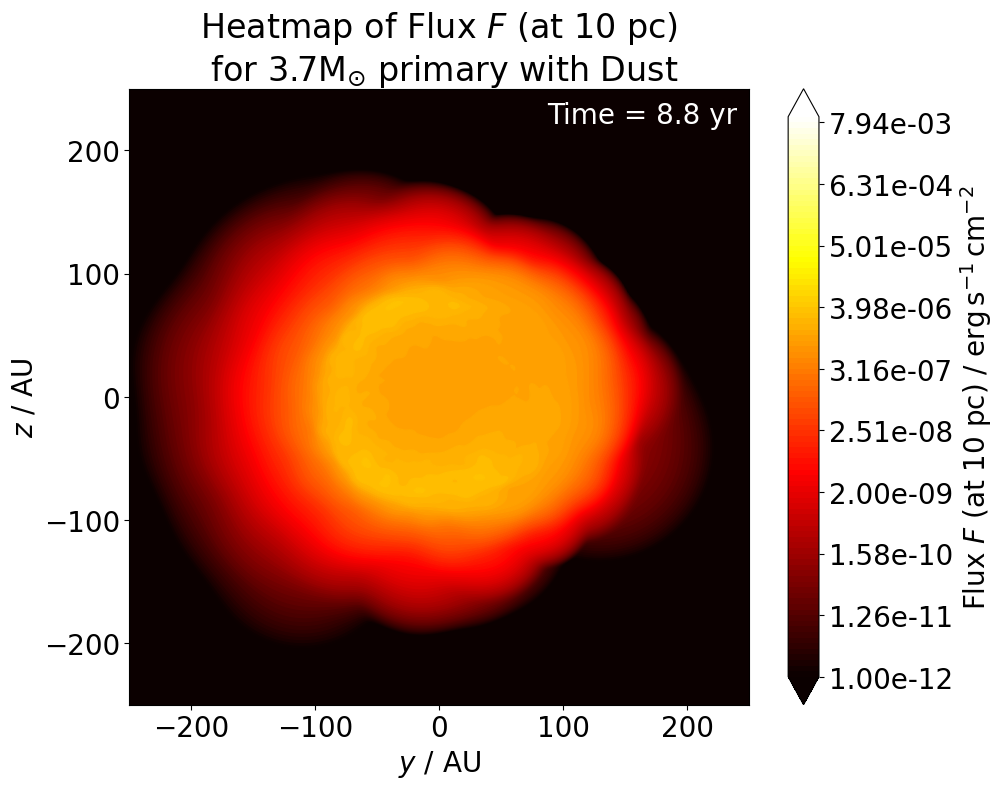

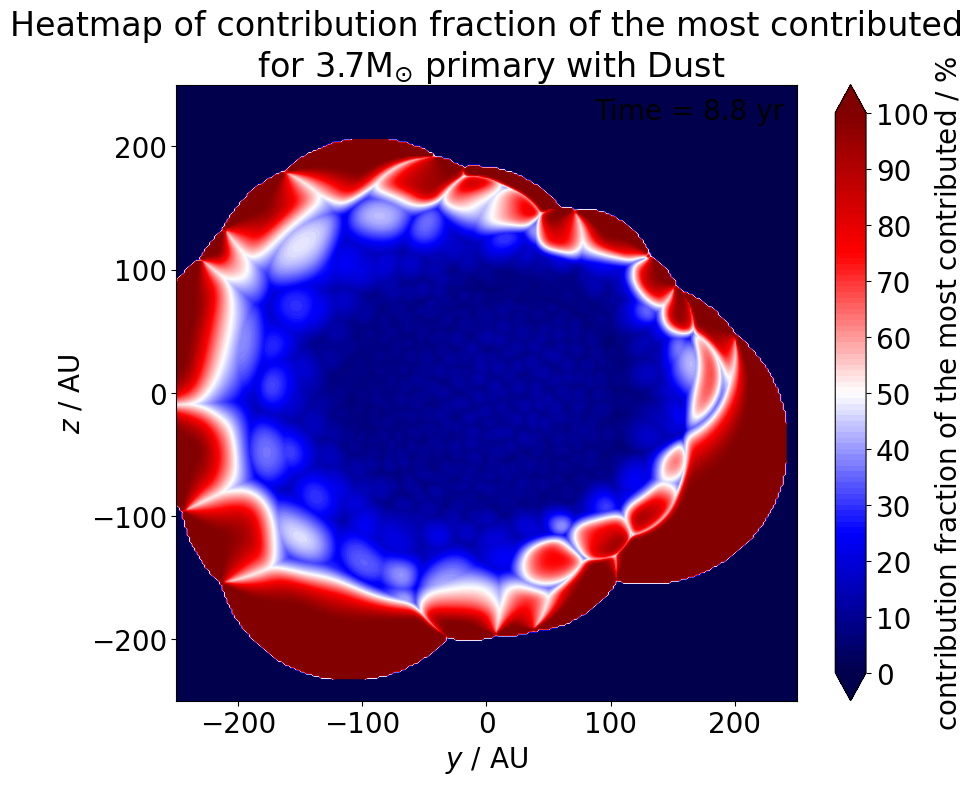

In [38]:
# transitioning
rays_res = 256
no_xy = (rays_res, rays_res)
no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
output_dir = f'../fig/20240222_LCGen/{no_xy_txt}/'


if __name__ == '__main__':

    

    outfilenames_dict = {
        'rads' : {},
        'contr': {},
    }

    figs = []
    for job_nickname in job_nicknames:
        data = {}
        plt.close('all')

        job_profile = JOB_PROFILES_DICT[job_nickname]
        job_name    = job_profile['job_name']
        file_indexes= job_profile['file_indexes']

        #for file_index in file_indexes: #[0, 1200, 4800, 8000, 17600]: #
        i_tr = 3560 if job_nickname not in {'2m_2022', '4m', '4md'} else 3500
        n_tr = 30
        file_index = i_tr

        plt.close('all')
        data_full = mupl.hdf5_load(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{no_xy_txt}.hdf5")
        xyzs_list = list(data_full.keys()).copy() if xyzs_list is None else xyzs_list
        
        # initialize
        for d in outfilenames_dict.keys():
            if job_nickname not in outfilenames_dict[d].keys():
                outfilenames_dict[d][job_nickname] = {xyzs: [] for xyzs in xyzs_list}

        for xyzs in xyzs_list:
            for ixylim, xylim_u in enumerate(np.linspace(100., 250., n_tr)*units.au):
                data = data_full[xyzs]
                # calc flux
                # rads = data['rads'].to(unit_I)
                flux = (data['rads']*data['area_per_ray']*units.rad**2 / spec_dist**2).to(unitsOut['flux'])
                
                # reconstructing rays
                rays_u = np.zeros((data['rays'].shape[0], 2, 3)) * units.au
                rays_u[:, 0, :2] = data['rays']
                rays_u[:, 1, :2] = data['rays']
                rays_u[:, 1] += data['ray_unit_vec'] * units.au

                # I_avg = (data['lum']/(4*pi*units.rad**2*data['area_one'])).to(unit_I)
                # I_range = np.min((20., (rads.max()/I_avg).cgs.value,)) * I_avg.value # rads.max().to(unit_I).value #
                I_avg = (data['lum']/(4*pi*spec_dist**2)*np.mean(data['area_per_ray']/data['area_one'])).to(unitsOut['flux'])
                I_range = np.min((20., (flux.max()/I_avg).cgs.value,)) * I_avg.value # flux.max().to(unit_I).value #
                

                # plotting

                for fig in figs:
                    fig.clear()
                    plt.close(fig)
                    del fig
                del figs
                figs = []
                
                cmap = plt.get_cmap('hot') #plt.get_cmap()
                #cmap.set_over('white')

                # xylim_u = 100*units.au if file_index<=3560 else 250*units.au
                
                fig, _, outfilenames = plot_heat(
                    no_xy, rays_u, flux,
                    data_label=f"Flux $F$ (at {spec_dist.value:.0f} {spec_dist.unit.to_string('latex_inline')})",
                    xyzs=xyzs, save_label=f"image-{ixylim:04d}",
                    job_profile=job_profile, file_index=file_index, cmap=cmap, notes=data,
                    norm=norm_image,
                    cbar_num_fmt=lambda x, pos: f"{x:.2e}",
                    facecolor=cmap.get_under(), text_color='white',
                    xylim=xylim_u.to_value(rays_u.unit),
                    output_dir=output_dir, out_exts=['png'], verbose=verbose_loop)
                outfilenames_dict['rads' ][job_nickname][xyzs].append(outfilenames[-1])
                figs.append(fig)
                
                fig, _, outfilenames = plot_heat(
                    no_xy, rays_u, data['contr'], data_label="contribution fraction of the most contributed",
                    xyzs=xyzs, save_label=f"contr-{ixylim:04d}",
                    job_profile=job_profile, file_index=file_index, cmap='seismic', notes=data,
                    ticks=10,
                    norm=mpl.colors.Normalize(0., 100.),
                    xylim=xylim_u.to_value(rays_u.unit),
                    output_dir=output_dir, out_exts=['png'], verbose=verbose_loop)
                outfilenames_dict['contr'][job_nickname][xyzs].append(outfilenames[-1])
                figs.append(fig)
                del data, rays_u, flux, I_avg, I_range
        del data_full
        gc.collect()

In [22]:
# generating movies (2md) (with 2 different fps speed- fixed to 1/6 second per 100 dumps)
if __name__ == '__main__':
    no_xy_txt = "256x256"
    job_nickname = '2md'
    # i_tr = 3560   # transitional frame index
    n_tr = 30     # transitional frame no
    for xyz in ['xyz', 'xzy', 'yzx']:
        input_dir = f'../fig/20240222_LCGen/{no_xy_txt}/'
        output_dir= f'../fig/20240222_LCGen/'
        for mode in ['image', 'contr']:
            fps1, outfilenames1 = 30, [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(   0,  i_tr,  20)
            ] + [
                f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{0:04d}_256x256.png"
            ]*5 + [
                f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{i_t:04d}_256x256.png" for i_t in range(n_tr)
            ] + [
                f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{n_tr-1:04d}_256x256.png"
            ]*5 + [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(i_tr,  5000,  20)
            ]
            fps2, outfilenames2 = 12, [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(5000, 9900+1,  50)
            ]
            moviefilename = f'{output_dir}heat_{job_nickname}__{xyz}_{mode}_{no_xy_txt}__movie-hollywood.mp4'
            with ImageSequenceClip(outfilenames1, fps=fps1) as vid1, ImageSequenceClip(outfilenames2, fps=fps2) as vid2:
                concatenate_videoclips((vid1, vid2)).write_videofile(moviefilename)

Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xyz_image_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xyz_image_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xyz_image_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xyz_contr_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xyz_contr_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xyz_contr_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xzy_image_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xzy_image_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xzy_image_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xzy_contr_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xzy_contr_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xzy_contr_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__yzx_image_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__yzx_image_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__yzx_image_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__yzx_contr_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__yzx_contr_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__yzx_contr_256x256__movie-hollywood.mp4


In [21]:
# generating movies (2md) (with 2 different fps speed- fixed to 1/6 second per 100 dumps - No transitioning)
if __name__ == '__main__':
    no_xy_txt = "256x256"
    job_nickname = '2md'
    file_index_final = JOB_PROFILES_DICT[job_nickname]['file_indexes'][-1]
    i_tr = 3560   # transitional frame index
    # n_tr = 30     # transitional frame no
    for xyz in ['xyz', 'xzy', 'yzx']:
        input_dir = f'../fig/20240222_LCGen/{no_xy_txt}/'
        output_dir= f'../fig/20240222_LCGen/'
        for mode in ['image', 'contr']:
            fps1, outfilenames1 = 30, [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(   0,  i_tr,  20)
            ] + [
            #     f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{0:04d}_256x256.png"
            # ]*5 + [
            #     f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{i_t:04d}_256x256.png" for i_t in range(n_tr)
            # ] + [
            #     f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{n_tr-1:04d}_256x256.png"
            # ]*5 + [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(i_tr,  5000,  20)
            ]
            fps2, outfilenames2 = 12, [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(5000, file_index_final+1,  50)
            ]
            moviefilename = f'{output_dir}heat_{job_nickname}__{xyz}_{mode}_{no_xy_txt}__movie.mp4'
            with ImageSequenceClip(outfilenames1, fps=fps1) as vid1, ImageSequenceClip(outfilenames2, fps=fps2) as vid2:
                concatenate_videoclips((vid1, vid2)).write_videofile(moviefilename)

Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xyz_image_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xyz_image_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xyz_image_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xyz_contr_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xyz_contr_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xyz_contr_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xzy_image_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xzy_image_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xzy_image_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__xzy_contr_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__xzy_contr_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__xzy_contr_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__yzx_image_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__yzx_image_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__yzx_image_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_2md__yzx_contr_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_2md__yzx_contr_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_2md__yzx_contr_256x256__movie.mp4


In [18]:
# generating movies (4md)
if __name__ == '__main__':
    no_xy_txt = "256x256"
    job_nickname = '4md'
    for xyz in ['xyz', 'xzy', 'yzx']:
        input_dir = f'../fig/20240222_LCGen/{no_xy_txt}/'
        output_dir= f'../fig/20240222_LCGen/'
        for mode in ['image', 'contr']:
            fps1, outfilenames1 =  6, [f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(0, 17600+1, 100)]
            moviefilename = f'{output_dir}heat_{job_nickname}__{xyz}_{mode}_{no_xy_txt}__movie.mp4'
            with ImageSequenceClip(outfilenames1, fps=fps1) as vid1:
                vid1.write_videofile(moviefilename)

Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xyz_image_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xyz_image_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xyz_image_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xyz_contr_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xyz_contr_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xyz_contr_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xzy_image_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xzy_image_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xzy_image_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xzy_contr_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xzy_contr_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xzy_contr_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__yzx_image_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__yzx_image_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__yzx_image_256x256__movie.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__yzx_contr_256x256__movie.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__yzx_contr_256x256__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__yzx_contr_256x256__movie.mp4


In [24]:
# generating movies (4md) (with transition- fixed to 1/6 second per 100 dumps)
if __name__ == '__main__':
    no_xy_txt = "256x256"
    job_nickname = '4md'
    i_tr = 3560 if job_nickname not in {'2m_2022', '4m', '4md'} else 3500
    for xyz in ['xyz', 'xzy', 'yzx']:
        input_dir = f'../fig/20240222_LCGen/{no_xy_txt}/'
        output_dir= f'../fig/20240222_LCGen/'
        for mode in ['image', 'contr']:
            fps1, outfilenames1 = 6, [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(   0,  i_tr, 100)
            ] + [
                f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{0:04d}_256x256.png"
            ]*int(5/5) + [
                f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{i_t:04d}_256x256.png" for i_t in range(0, n_tr, 5)
            ] + [
                f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{n_tr-1:04d}_256x256.png"
            ]*int(5/5) + [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(i_tr,  5000+1, 100)
            ]
            moviefilename = f'{output_dir}heat_{job_nickname}__{xyz}_{mode}_{no_xy_txt}__movie-hollywood.mp4'
            with ImageSequenceClip(outfilenames1, fps=fps1) as vid1:
                vid1.write_videofile(moviefilename)

Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xyz_image_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xyz_image_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xyz_image_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xyz_contr_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xyz_contr_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xyz_contr_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xzy_image_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xzy_image_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xzy_image_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__xzy_contr_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__xzy_contr_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__xzy_contr_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__yzx_image_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__yzx_image_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__yzx_image_256x256__movie-hollywood.mp4
Moviepy - Building video ../fig/20240222_LCGen/heat_4md__yzx_contr_256x256__movie-hollywood.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4md__yzx_contr_256x256__movie-hollywood.mp4



Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4md__yzx_contr_256x256__movie-hollywood.mp4


In [42]:
# generating movies (2m) (with 2 different fps speed- fixed to 1/6 second per 100 dumps)
if __name__ == '__main__':
    no_xy_txt = "256x256"
    job_nickname = '4m' #'2m_2022'
    i_tr = 3500   # transitional frame index
    n_tr = 30     # transitional frame no
    for xyz in ['xyz', 'xzy', 'yzx']:
        input_dir = f'../fig/20240222_LCGen/{no_xy_txt}/'
        output_dir= f'../fig/20240222_LCGen/'
        for mode in ['image', 'contr']:
            fps1, outfilenames1 = 6, [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(   0,  i_tr+1, 100)
            ] + [
                f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{0:04d}_256x256.png"
            ]*1
            fps2, outfilenames2 = 30, [
                f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{i_t:04d}_256x256.png" for i_t in range(n_tr)
            ]
            fps3, outfilenames3 = 6, [
                f"{input_dir}heat_{job_nickname}_{i_tr:05d}_{xyz}_{mode}-{n_tr-1:04d}_256x256.png"
            ]*1 + [
                f"{input_dir}heat_{job_nickname}_{i:05d}_{xyz}_{mode}_256x256.png" for i in range(i_tr+100, 5000+1, 100)
            ] 
            moviefilename = f'{output_dir}heat_{job_nickname}__{xyz}_{mode}_{no_xy_txt}__movie.for-public.mp4'
            with ImageSequenceClip(
                outfilenames1, fps=fps1) as vid1,  ImageSequenceClip(
                outfilenames2, fps=fps2) as vid2,  ImageSequenceClip(
                outfilenames3, fps=fps3) as vid3:
                concatenate_videoclips((vid1, vid2, vid3)).write_videofile(moviefilename)

t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:09<00:01, 59.80it/s, now=None]

Moviepy - Building video ../fig/20240222_LCGen/heat_4m__xyz_image_256x256__movie.for-public.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4m__xyz_image_256x256__movie.for-public.mp4




t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:14<00:01, 59.80it/s, now=None]

Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4m__xyz_image_256x256__movie.for-public.mp4


t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:15<00:01, 59.80it/s, now=None]

Moviepy - Building video ../fig/20240222_LCGen/heat_4m__xyz_contr_256x256__movie.for-public.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4m__xyz_contr_256x256__movie.for-public.mp4




t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:21<00:01, 59.80it/s, now=None]

Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4m__xyz_contr_256x256__movie.for-public.mp4


t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:22<00:01, 59.80it/s, now=None]

Moviepy - Building video ../fig/20240222_LCGen/heat_4m__xzy_image_256x256__movie.for-public.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4m__xzy_image_256x256__movie.for-public.mp4




t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:28<00:01, 59.80it/s, now=None]

Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4m__xzy_image_256x256__movie.for-public.mp4


t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:29<00:01, 59.80it/s, now=None]

Moviepy - Building video ../fig/20240222_LCGen/heat_4m__xzy_contr_256x256__movie.for-public.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4m__xzy_contr_256x256__movie.for-public.mp4




t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:35<00:01, 59.80it/s, now=None]

Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4m__xzy_contr_256x256__movie.for-public.mp4


t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:36<00:01, 59.80it/s, now=None]

Moviepy - Building video ../fig/20240222_LCGen/heat_4m__yzx_image_256x256__movie.for-public.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4m__yzx_image_256x256__movie.for-public.mp4




t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:42<00:01, 59.80it/s, now=None]

Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4m__yzx_image_256x256__movie.for-public.mp4


t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:43<00:01, 59.80it/s, now=None]

Moviepy - Building video ../fig/20240222_LCGen/heat_4m__yzx_contr_256x256__movie.for-public.mp4.
Moviepy - Writing video ../fig/20240222_LCGen/heat_4m__yzx_contr_256x256__movie.for-public.mp4




t:  64%|███████████████████████████████████████████▍                        | 189/296 [00:49<00:01, 59.80it/s, now=None]

Moviepy - Done !
Moviepy - video ready ../fig/20240222_LCGen/heat_4m__yzx_contr_256x256__movie.for-public.mp4


### Selected few plots

In [20]:
# tbp = to be plotted
output_dir= f'../fig/20240222_LCGen/'
file_indexes_tbp = [0, 1200, 2000, 4800, 17600]
no_xy_txt = "256x256"
norm_image = mpl.colors.LogNorm(1e-12, 1e-2, clip=False)

#### image and contr

*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_00000.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_01200.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_02000.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_04800.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_17600.lcgen.256x256.hdf5  (compress=False)
Saved to ../fig/20240222_LCGen/image_4md_256x256.pdf
Saved to ../fig/20240222_LCGen/image_4md_256x256.png


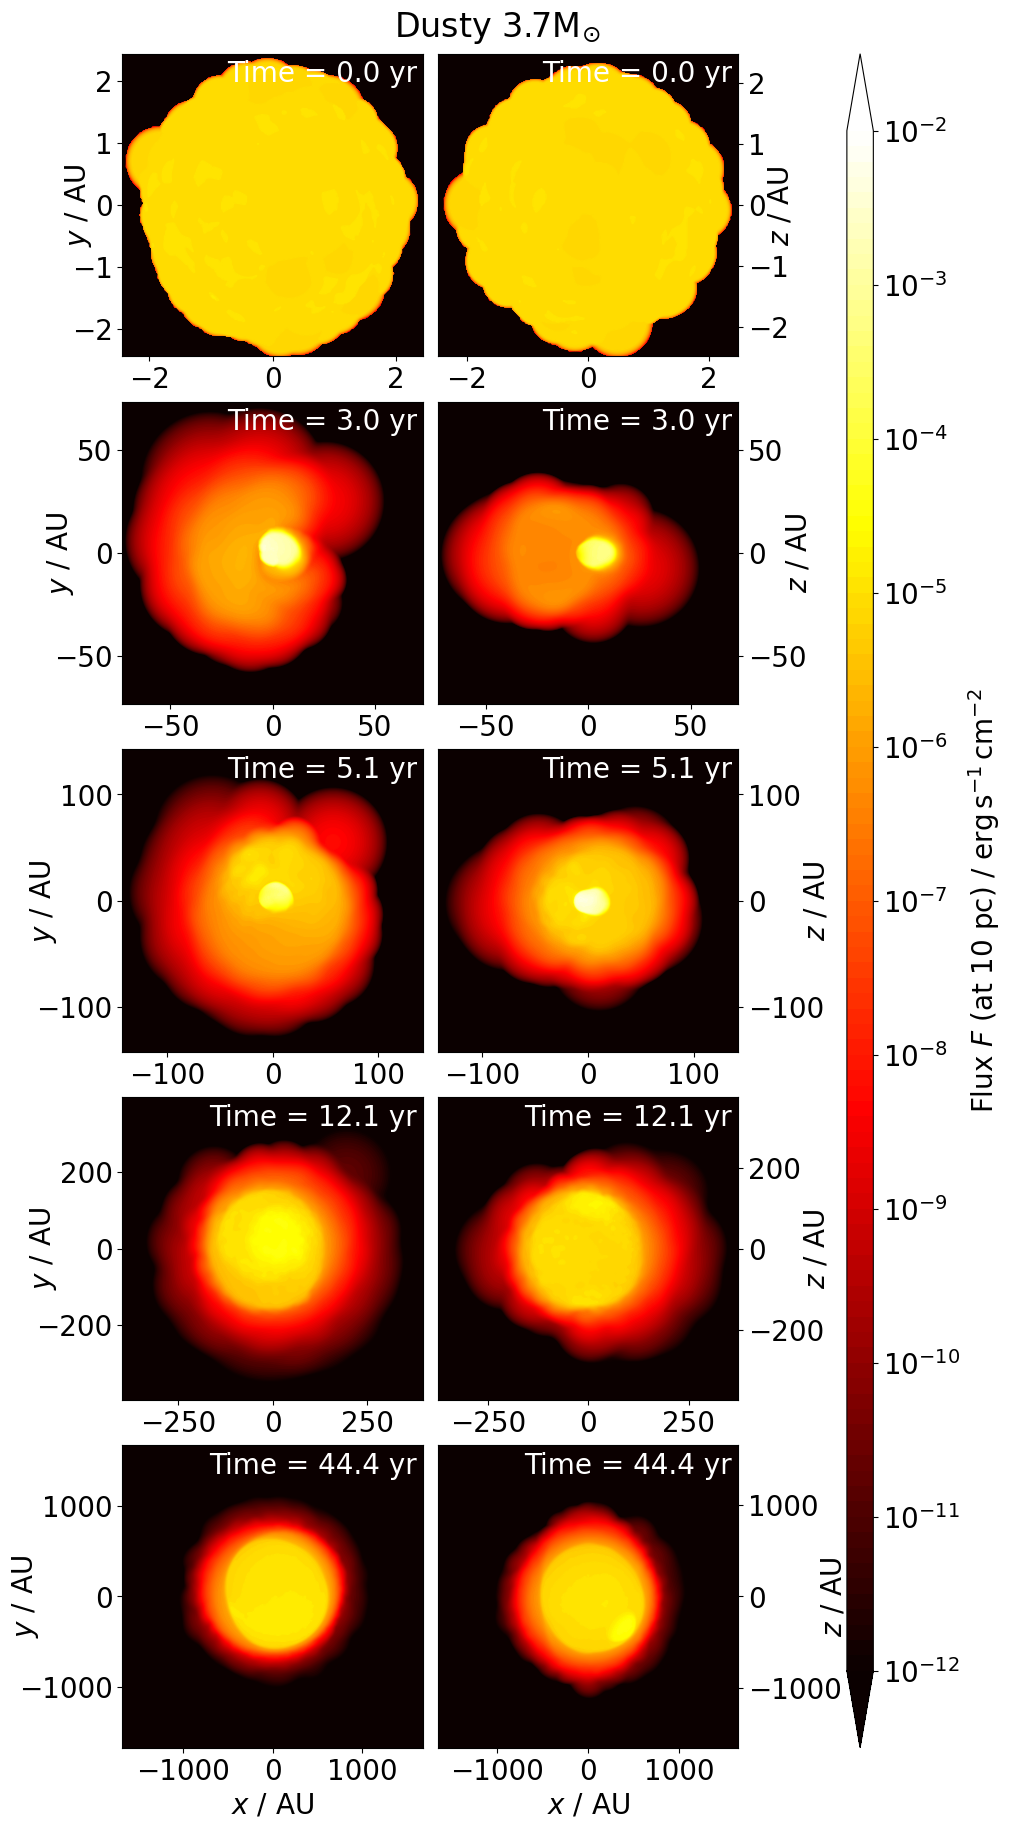

In [122]:
# plot image
if __name__ == '__main__':

    xyzs_list = ['xyz', 'xzy']
    job_nickname = '4md'
    out_savename = get_out_savename([job_nickname])
    
    job_profile = JOB_PROFILES_DICT[job_nickname]
    job_name    = job_profile['job_name']
    
    plt.close('all')
    nrow, ncol = len(file_indexes_tbp), len(xyzs_list)
    fig, axes = plt.subplots(nrow, ncol, figsize=(10, 22))
    fig.subplots_adjust(hspace=0.15, wspace=0.05)
    ylabelcoord_dict = {}

    for ifile, file_index in enumerate(file_indexes_tbp):
        try:
            data_full = mupl.hdf5_load(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{no_xy_txt}.hdf5")

            for ixyz, xyzs in enumerate(xyzs_list):
                irow, icol = ifile, ixyz
                ax = axes[irow, icol]
                data = data_full[xyzs]
                
                # calc flux
                y = (data['rads']*data['area_per_ray']*units.rad**2 / spec_dist**2).to(unitsOut['flux'])
                
                # reconstructing rays
                rays_u = np.zeros((data['rays'].shape[0], 2, 3)) * units.au
                rays_u[:, 0, :2] = data['rays']
                rays_u[:, 1, :2] = data['rays']
                rays_u[:, 1] += data['ray_unit_vec'] * units.au
                
                # plotting
                _, cax, _ = plot_heat(
                    no_xy, rays_u, y,
                    fig=fig, ax=ax, plot_cbar=False, out_exts=[],
                    xyzs=xyzs, save_label=f"image",
                    job_profile=job_profile, file_index=file_index, cmap='hot', notes=data,
                    norm=norm_image,
                    #norm=mpl.colors.LogNorm(5e5, 1e9, clip=False),
                    text_color='white', ylabelpad=-16,
                    # xylim=xylim_u.to_value(rays_u.unit),
                    output_dir=None, verbose=verbose_loop)

                if irow != nrow-1: ax.set_xlabel('')
                if icol == ncol-1: ax.yaxis.set_label_position("right"); ax.yaxis.tick_right()

                # fig, _, outfilenames = plot_heat(
                #     no_xy, rays_u, data['contr'], data_label="contribution fraction of the most contributed",
                #     xyzs=xyzs, save_label=f"contr",
                #     job_profile=job_profile, file_index=file_index, cmap='seismic', notes=data,
                #     ticks=10,
                #     norm=mpl.colors.Normalize(0., 100.),
                #     text_color='white',
                #     output_dir=output_dir, out_exts=['png'], verbose=verbose_loop)
                # outfilenames_dict['contr'][job_nickname][xyzs].append(outfilenames[-1])
        except (FileNotFoundError, BlockingIOError) as e:
            print("*** Error:", e)

    data_label=f"Flux $F$ (at {spec_dist.value:.0f} {spec_dist.unit.to_string('latex_inline')})"
    cbar_num_fmt=lambda x, pos: f"$10^{{{(np.log10(x)):.0f}}}$" #lambda x, pos: f"{x:.2e}"
    ticks = 10**np.arange(np.ceil(np.log10(norm.vmin)), np.floor(np.log10(norm.vmax))+.01)
    cbar= fig.colorbar(
        cax, ax=axes,
        label=f"{data_label} / {y.unit.to_string('latex_inline')}", ticks=ticks, format=cbar_num_fmt,
        fraction=0.065, pad=0.14, aspect=64,
    )

    fig.suptitle(job_profile['name'], verticalalignment='top', y=0.9)
    
    outfilename_noext = f"{output_dir}image_{job_nickname}_{no_xy_txt}"
    
    fig.savefig(f"{outfilename_noext}.pdf")
    print(f"Saved to {outfilename_noext}.pdf")
    fig.savefig(f"{outfilename_noext}.png")
    print(f"Saved to {outfilename_noext}.png")

*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00000.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_01200.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_02000.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_04800.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_17600.lcgen.256x256.hdf5  (compress=False)
Saved to ../fig/20240222_LCGen/contr_2md_256x256.pdf
Saved to ../fig/20240222_LCGen/contr_2md_256x256.png


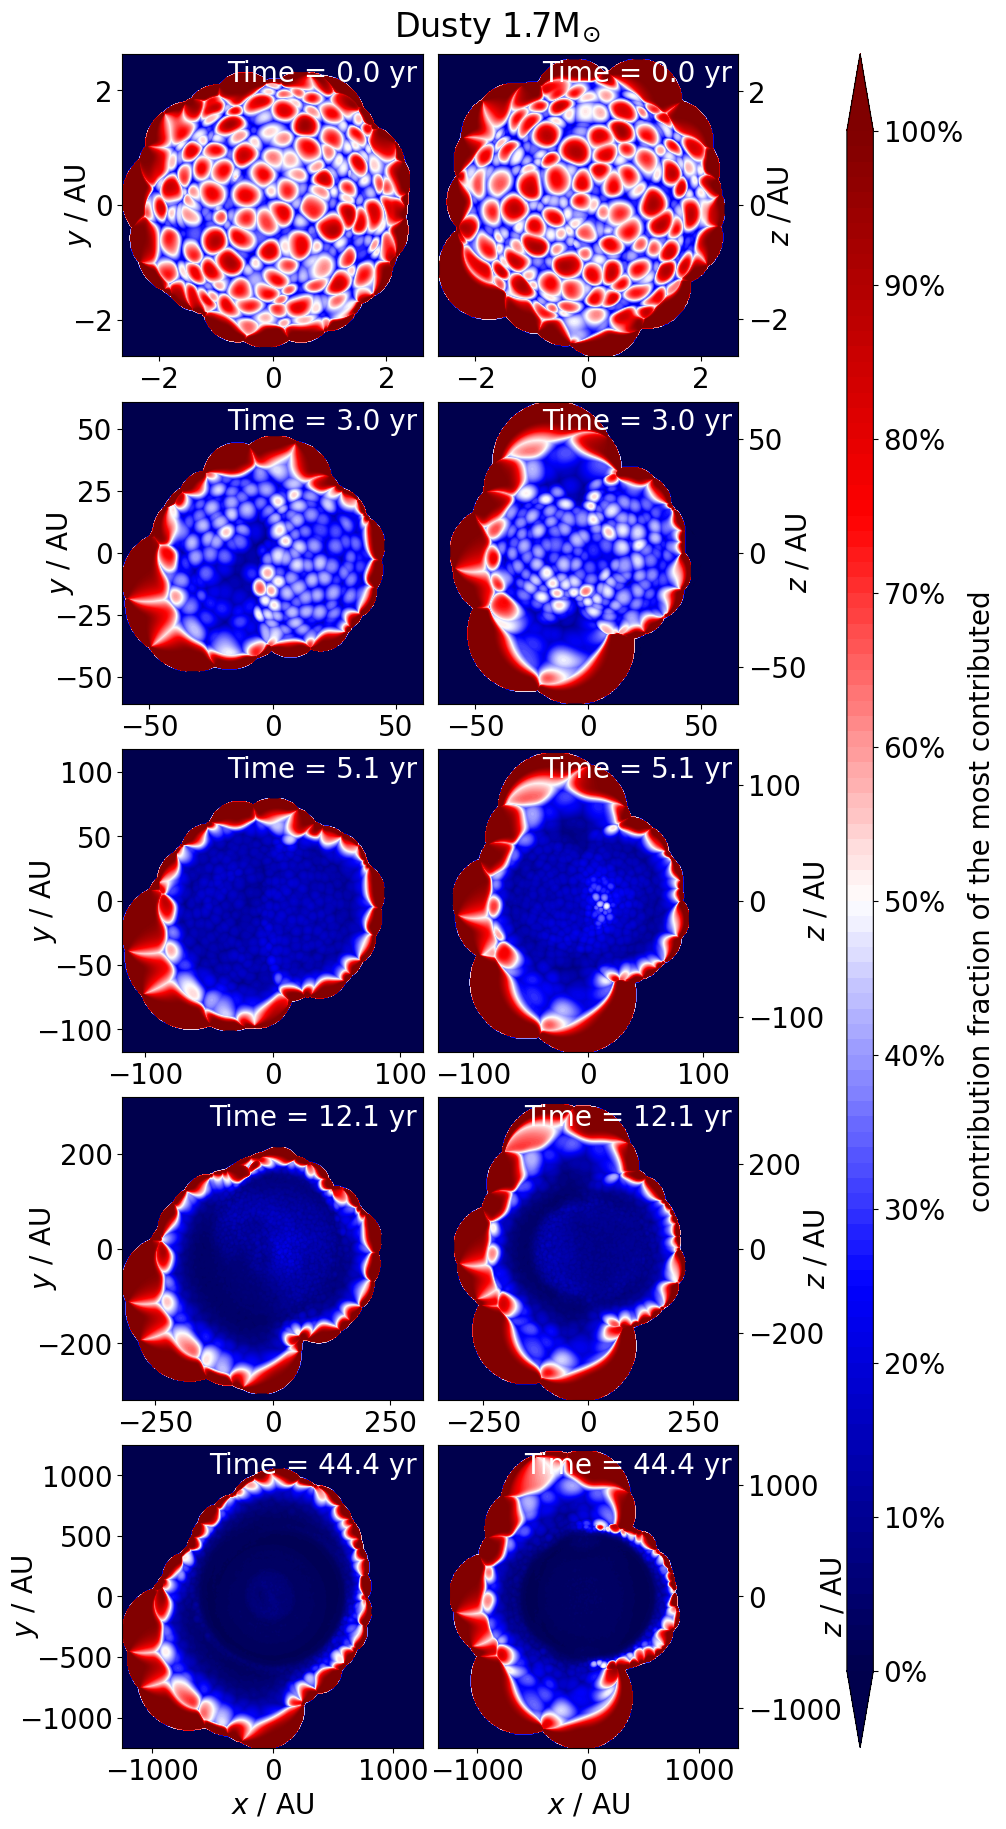

In [23]:
# plot contr
if __name__ == '__main__':

    xyzs_list = ['xyz', 'xzy']
    job_nickname = '2md'
    out_savename = get_out_savename([job_nickname])
    
    plt.close('all')
    nrow, ncol = len(file_indexes_tbp), len(xyzs_list)
    fig, axes = plt.subplots(nrow, ncol, figsize=(10, 22))
    fig.subplots_adjust(hspace=0.15, wspace=0.05)

    for ifile, file_index in enumerate(file_indexes_tbp):
        job_profile = JOB_PROFILES_DICT[job_nickname]
        job_name    = job_profile['job_name']
        try:
            data_full = mupl.hdf5_load(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{no_xy_txt}.hdf5")

            for ixyz, xyzs in enumerate(xyzs_list):
                irow, icol = ifile, ixyz
                ax = axes[irow, icol]
                data = data_full[xyzs]
                
                # reconstructing rays
                rays_u = np.zeros((data['rays'].shape[0], 2, 3)) * units.au
                rays_u[:, 0, :2] = data['rays']
                rays_u[:, 1, :2] = data['rays']
                rays_u[:, 1] += data['ray_unit_vec'] * units.au
                
                # plotting
                y = data['contr']
                norm = mpl.colors.Normalize(0., 100.)
                _, cax, _ = plot_heat(
                    no_xy, rays_u, y,
                    fig=fig, ax=ax, plot_cbar=False, out_exts=[],
                    xyzs=xyzs, save_label=f"contr",
                    job_profile=job_profile, file_index=file_index, cmap='seismic', notes=data,
                    norm=norm,
                    text_color='white', ylabelpad=-16,
                    output_dir=None, verbose=verbose_loop)

                if irow != nrow-1: ax.set_xlabel('')
                if icol == ncol-1: ax.yaxis.set_label_position("right"); ax.yaxis.tick_right()



        except (FileNotFoundError, BlockingIOError) as e:
            print("*** Error:", e)

    data_label="contribution fraction of the most contributed"
    ticks = np.linspace(norm.vmin, norm.vmax, 10+1)
    cbar_num_fmt=lambda x, pos: f"{x:.0f}$\\%$"
    cbar= fig.colorbar(
        cax, ax=axes,
        label=f"{data_label}", ticks=ticks, format=cbar_num_fmt,
        fraction=0.065, pad=0.14, aspect=64,
    )

    fig.suptitle(job_profile['name'], verticalalignment='top', y=0.9)
    
    outfilename_noext = f"{output_dir}contr_{job_nickname}_{no_xy_txt}"
    
    fig.savefig(f"{outfilename_noext}.pdf")
    print(f"Saved to {outfilename_noext}.pdf")
    fig.savefig(f"{outfilename_noext}.png")
    print(f"Saved to {outfilename_noext}.png")

    # plot image
    if __name__ == '__main__':
    
        xyzs_list = ['xyz', 'xzy']
    
    
        # job_nickname = '2md'
        job_nicknames = ['2md', '4md'] # ['2md']
        out_savename = get_out_savename(job_nicknames)
        for job_nickname in job_nicknames:
        
            job_profile = JOB_PROFILES_DICT[job_nickname]
            job_name    = job_profile['job_name']
            
            plt.close('all')
            nrow, ncol = len(file_indexes_tbp), len(xyzs_list)
            fig, axes = plt.subplots(nrow, ncol, figsize=(10, 22))
            fig.subplots_adjust(hspace=0.15, wspace=0.05)
        
            for ifile, file_index in enumerate(file_indexes_tbp):
                try:
                    data_full = mupl.hdf5_load(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{no_xy_txt}.hdf5")
        
                    for ixyz, xyzs in enumerate(xyzs_list):
                        irow, icol = ifile, ixyz
                        ax = axes[irow, icol]
                        data = data_full[xyzs]
                        
                        # calc flux
                        y = (data['rads']*data['area_per_ray']*units.rad**2 / spec_dist**2).to(unitsOut['flux'])
                        
                        # reconstructing rays
                        rays_u = np.zeros((data['rays'].shape[0], 2, 3)) * units.au
                        rays_u[:, 0, :2] = data['rays']
                        rays_u[:, 1, :2] = data['rays']
                        rays_u[:, 1] += data['ray_unit_vec'] * units.au
                        
                        # plotting
                        norm = mpl.colors.LogNorm(1e-12, 1e-2, clip=False)
                        _, cax, _ = plot_heat(
                            no_xy, rays_u, y,
                            fig=fig, ax=ax, plot_cbar=False, out_exts=[],
                            xyzs=xyzs, save_label=f"image",
                            job_profile=job_profile, file_index=file_index, cmap='hot', notes=data,
                            norm=norm,
                            #norm=mpl.colors.LogNorm(5e5, 1e9, clip=False),
                            text_color='white', ylabelpad=-16,
                            # xylim=xylim_u.to_value(rays_u.unit),
                            output_dir=None, verbose=verbose_loop)
        
                        if irow != nrow-1: ax.set_xlabel('')
                        if icol == ncol-1: ax.yaxis.set_label_position("right"); ax.yaxis.tick_right()
        
        
                        # fig, _, outfilenames = plot_heat(
                        #     no_xy, rays_u, data['contr'], data_label="contribution fraction of the most contributed",
                        #     xyzs=xyzs, save_label=f"contr",
                        #     job_profile=job_profile, file_index=file_index, cmap='seismic', notes=data,
                        #     ticks=10,
                        #     norm=mpl.colors.Normalize(0., 100.),
                        #     text_color='white',
                        #     output_dir=output_dir, out_exts=['png'], verbose=verbose_loop)
                        # outfilenames_dict['contr'][job_nickname][xyzs].append(outfilenames[-1])
                except (FileNotFoundError, BlockingIOError) as e:
                    print("*** Error:", e)
    
        data_label="Specific intensity $I$"
        cbar_num_fmt=lambda x, pos: f"$10^{{{(np.log10(x)):.0f}}}$" #lambda x, pos: f"{x:.2e}"
        ticks = 10**np.arange(np.ceil(np.log10(norm.vmin)), np.floor(np.log10(norm.vmax))+.01)
        cbar= fig.colorbar(
            cax, ax=axes,
            label=f"{data_label} / {y.unit.to_string('latex_inline')}", ticks=ticks, format=cbar_num_fmt,
            fraction=0.065, pad=0.14, aspect=32,
        )
    
        fig.suptitle(job_profile['name'], verticalalignment='top', y=0.9)
    
        
        outfilename_noext = f"{output_dir}image_{job_nickname}_{no_xy_txt}"
        
        fig.savefig(f"{outfilename_noext}.pdf")
        print(f"Saved to {outfilename_noext}.pdf")
        fig.savefig(f"{outfilename_noext}.png")
        print(f"Saved to {outfilename_noext}.png")

#### SED / Spec

*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_00000.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_00000.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_01200.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_01200.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_02000.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_02000.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/2md_04800.lcgen.256x256.hdf5  (compress=False)
*   Note   :    run_code() ==> <module>() ==> hdf5_load():
	Reading from ../interm/4md_048

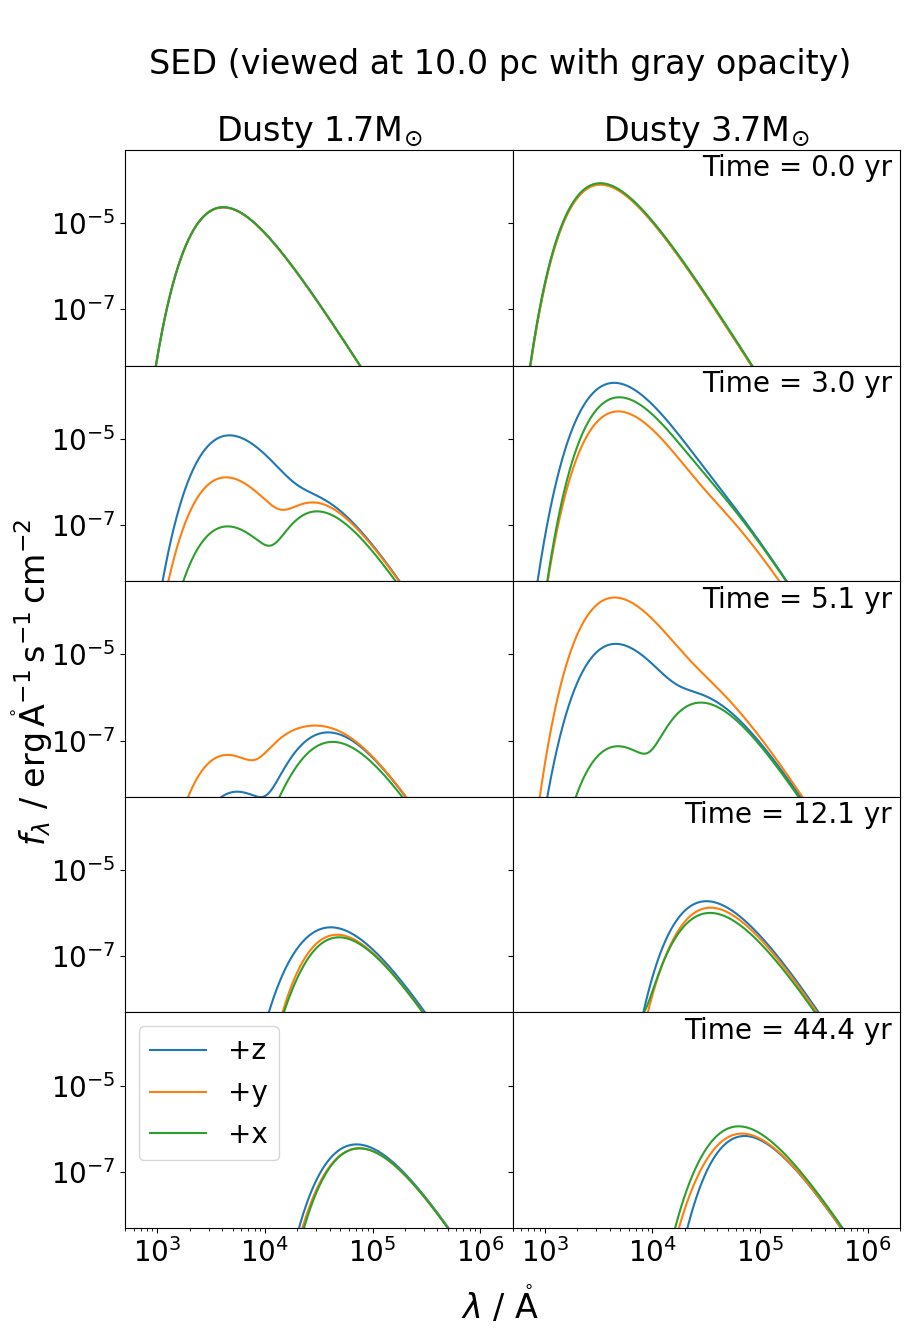

In [19]:
# plot SED

if __name__ == '__main__':

    job_nicknames = ['2md', '4md']
    out_savename = get_out_savename(job_nicknames)

    # spec_dist = 10 * units.parsec
    # unit_flux = (units.erg / units.s / units.cm**2) / units.angstrom

    plt.close('all')
    nrow, ncol = len(file_indexes_tbp), len(job_nicknames)
    fig, axes = plt.subplots(nrow, ncol, figsize=(5*ncol, 3*nrow-1), sharex=True, sharey=True, squeeze=False)
    fig.subplots_adjust(hspace=0.0, wspace=0.0)

    for ifile, file_index in enumerate(file_indexes_tbp):
        for ijob, job_nickname in enumerate(job_nicknames):
            irow, icol = ifile, ijob
            ax = axes[irow, icol]

            job_profile = JOB_PROFILES_DICT[job_nickname]
            job_name    = job_profile['job_name']

            data_full = mupl.hdf5_load(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{no_xy_txt}.hdf5")
            xyzs_list = list(data_full.keys()).copy() if xyzs_list is None else xyzs_list

            
            for xyzs in xyzs_list:
                data = data_full[xyzs]
                L_wavs = data['L_wavs']
                wavlens = data['wavlens']
                y = (L_wavs/(4*pi*spec_dist**2)).to(unitsOut['flux_wav'])
                x = wavlens.to(units.angstrom)
                ax.loglog(x, y, label=f"+{xyzs[2]}")

            if irow == 0:
                ax.set_title(job_profile['name'])
            ax.set_xlim(5e2, 2e6)
            ax.set_ylim(5e-9, 5e-4)
            if icol == ncol-1:
                ax.text(
                    0.98, 0.98,
                    f"Time = {data['time']:.1f}\n",
                    #color = "black",
                    ha = 'right', va = 'top',
                    transform=ax.transAxes,
                )
            if icol == 0 and irow == nrow-1:
                ax.legend()

    
    outfilename_noext = f"{output_dir}Spec_{no_xy_txt}"

    fig.supxlabel(f"$\\lambda$ / {x.unit.to_string('latex_inline')}", y=0.04)
    fig.supylabel(f"$f_{{\\lambda}}$ / {y.unit.to_string('latex_inline')}", x=0.01)
    
    fig.savefig(f"{outfilename_noext}.pdf")
    print(f"Saved to {outfilename_noext}.pdf")

    title_txt = f"\nSED (viewed at {spec_dist:.1f} with gray opacity)"
    if len(job_nicknames) > 1:
        fig.suptitle(title_txt)
    else:
        axes[0, 0].set_title(title_txt)
    fig.savefig(f"{outfilename_noext}.png")
    print(f"Saved to {outfilename_noext}.png")

*   Note   :    <module>() ==> plot_SED_2md_only() ==> hdf5_load():
	Reading from ../interm/2md_00000.lcgen.256x256.hdf5  (compress=False)
*   Note   :    <module>() ==> plot_SED_2md_only() ==> hdf5_load():
	Reading from ../interm/2md_00800.lcgen.256x256.hdf5  (compress=False)
*   Note   :    <module>() ==> plot_SED_2md_only() ==> hdf5_load():
	Reading from ../interm/2md_01200.lcgen.256x256.hdf5  (compress=False)
*   Note   :    <module>() ==> plot_SED_2md_only() ==> hdf5_load():
	Reading from ../interm/2md_01600.lcgen.256x256.hdf5  (compress=False)
*   Note   :    <module>() ==> plot_SED_2md_only() ==> hdf5_load():
	Reading from ../interm/2md_04800.lcgen.256x256.hdf5  (compress=False)
*   Note   :    <module>() ==> plot_SED_2md_only() ==> hdf5_load():
	Reading from ../interm/2md_17600.lcgen.256x256.hdf5  (compress=False)
Saved to ../fig/20240222_LCGen/Spec_2md_256x256.pdf
Saved to ../fig/20240222_LCGen/Spec_2md_256x256.png


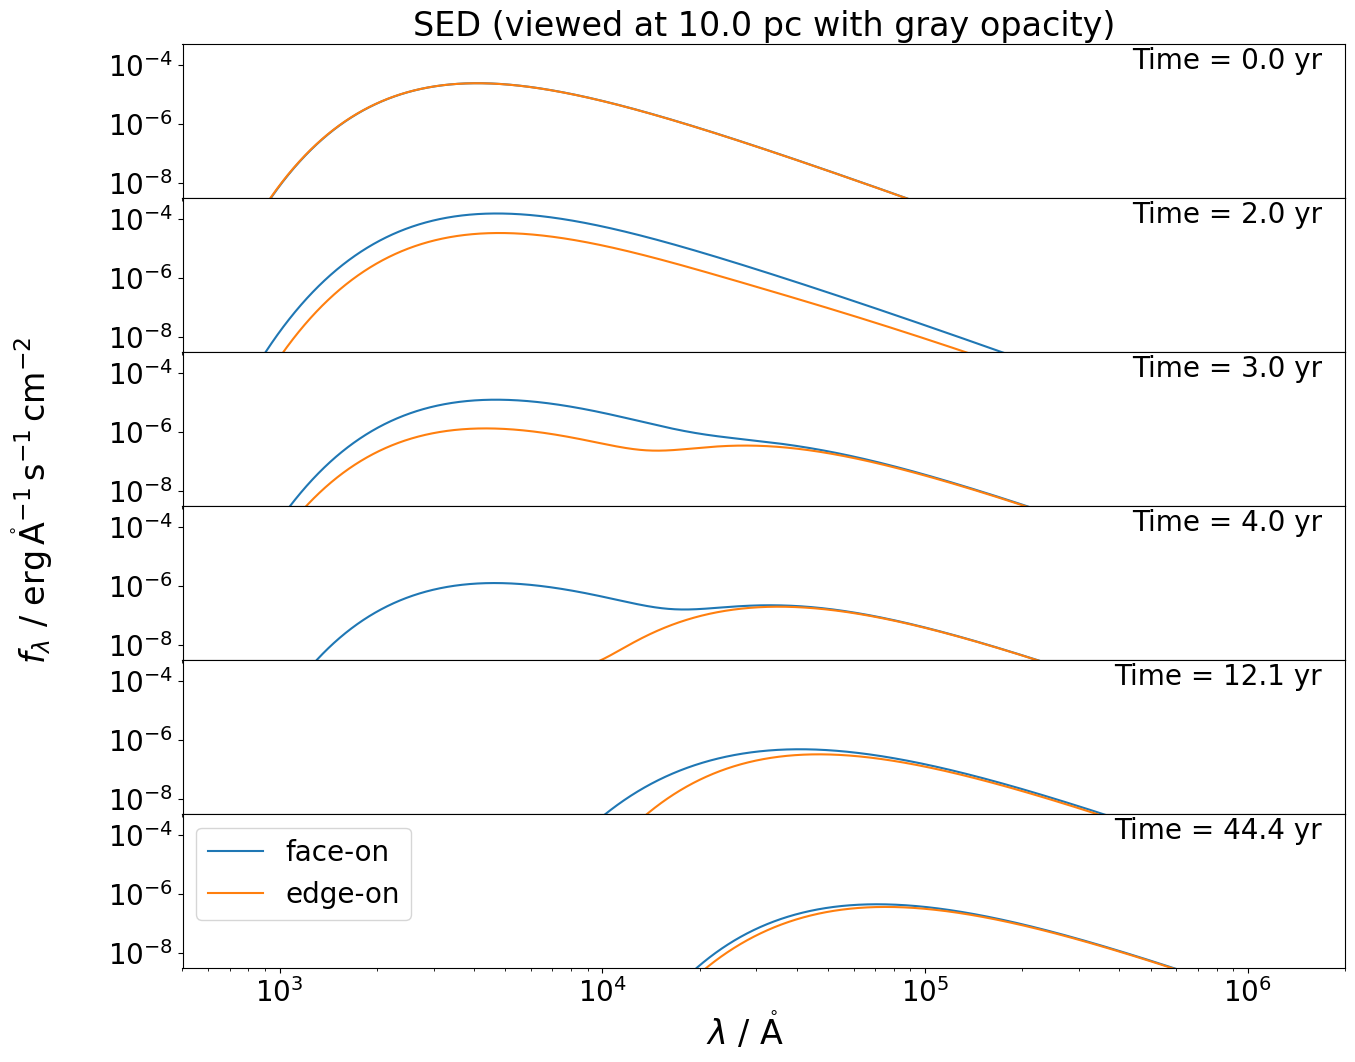

In [58]:
# plot SED (2md only)

def plot_SED_2md_only():

    job_nicknames = ['2md']
    out_savename = get_out_savename(job_nicknames)
    file_indexes_tbp = [0, 800, 1200, 1600, 4800, 17600]
    xyzs_list = ['xyz', 'xzy']
    
    # spec_dist = 10 * units.parsec
    # unit_flux = (units.erg / units.s / units.cm**2) / units.angstrom

    plt.close('all')
    nrow, ncol = len(file_indexes_tbp), len(job_nicknames)
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 12), sharex=True, sharey=True, squeeze=False)
    fig.subplots_adjust(hspace=0.0, wspace=0.0)

    for ifile, file_index in enumerate(file_indexes_tbp):
        for ijob, job_nickname in enumerate(job_nicknames):
            irow, icol = ifile, ijob
            ax = axes[irow, icol]

            job_profile = JOB_PROFILES_DICT[job_nickname]
            job_name    = job_profile['job_name']

            data_full = mupl.hdf5_load(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{no_xy_txt}.hdf5")
            xyzs_list = list(data_full.keys()).copy() if xyzs_list is None else xyzs_list

            
            for xyzs in xyzs_list:
                data = data_full[xyzs]
                L_wavs = data['L_wavs']
                wavlens = data['wavlens']
                y = (L_wavs/(4*pi*spec_dist**2)).to(unitsOut['flux_wav'])
                x = wavlens.to(units.angstrom)
                ax.loglog(x, y, label="face-on" if  xyzs[2] == 'z' else "edge-on")

            if irow == 0:
                ax.set_title(job_profile['name'])
            ax.set_xlim(5e2, 2e6)
            ax.set_ylim(3e-9, 5e-4)
            ax.set_yticks([1e-8, 1e-6, 1e-4])
            if icol == ncol-1:
                ax.text(
                    0.98, 0.98,
                    f"Time = {data['time']:.1f}\n",
                    #color = "black",
                    ha = 'right', va = 'top',
                    transform=ax.transAxes,
                )
            if icol == 0 and irow == nrow-1:
                ax.legend()

    
    outfilename_noext = f"{output_dir}Spec_2md_{no_xy_txt}"

    fig.supxlabel(f"$\\lambda$ / {x.unit.to_string('latex_inline')}", y=0.04)
    fig.supylabel(f"$f_{{\\lambda}}$ / {y.unit.to_string('latex_inline')}", x=0.01)
    
    fig.savefig(f"{outfilename_noext}.pdf")
    print(f"Saved to {outfilename_noext}.pdf")

    title_txt = f"SED (viewed at {spec_dist:.1f} with gray opacity)"
    if len(job_nicknames) > 1:
        fig.suptitle(title_txt)
    else:
        axes[0, 0].set_title(title_txt)
    fig.savefig(f"{outfilename_noext}.png")
    print(f"Saved to {outfilename_noext}.png")
    return fig, ax

if __name__ == '__main__':
    fig, ax = plot_SED_2md_only()

In [53]:
help(ax.set_yticks)

Help on method set_yticks in module matplotlib.axes._base:

set_yticks(ticks, labels=None, *, minor=False, **kwargs) method of matplotlib.axes._axes.Axes instance
    Set the yaxis' tick locations and optionally tick labels.

    If necessary, the view limits of the Axis are expanded so that all
    given ticks are visible.

    Parameters
    ----------
    ticks : 1D array-like
        Array of tick locations (either floats or in axis units). The axis
        `.Locator` is replaced by a `~.ticker.FixedLocator`.

        Pass an empty list (``set_yticks([])``) to remove all ticks.

        Some tick formatters will not label arbitrary tick positions;
        e.g. log formatters only label decade ticks by default. In
        such a case you can set a formatter explicitly on the axis
        using `.Axis.set_major_formatter` or provide formatted
        *labels* yourself.

    labels : list of str, optional
        Tick labels for each location in *ticks*; must have the same length as
 

### Getting initial MESA profile vs relaxed phantom profile

In [156]:
def plot_stuff(
    stuff_dict: dict,
    x_name: str, y_name: str, mpdf, job_profile,
    xlim: tuple[float, float]=(1., 1.e3),
    ylim = None,
):
    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))
    xs, ys = stuff_dict[x_name], stuff_dict[y_name]
    if isinstance(xs, units.Quantity): xs = xs.value
    if isinstance(ys, units.Quantity): ys = ys.value
    if xlim is None: mask = np.ones_like(xs, dtype=np.bool_)
    else: mask = np.logical_and(xlim[0] < xs, xs < xlim[1])
    ax.loglog(xs[mask], ys[mask], '.')
    ax.set_xlabel(f"{x_name} / {stuff_dict[x_name].unit.to_string('latex_inline')}")
    ax.set_ylabel(f"{y_name} / {stuff_dict[y_name].unit.to_string('latex_inline')}")
    ax.text(
        0.98, 0.98, f"Time = {mpdf.get_time()}",
        ha = 'right', va = 'top', transform=ax.transAxes,
    )
    # ax.set_title(f"scatter plot of all particles\n{job_profile['plot_title_suffix']}")
    ax.set_xlim(xlim)
    return fig, ax, mask

In [143]:
# Test
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
ray = mupl.get_rays(mpdf.data['sink'][['x', 'y', 'z']].iloc[0], np.array([0., 0., 1.]))
srcfuncs = mpdf.const['sigma_sb'] * sdf['T']**4 #/ (4 * pi)

*   Note   :    <module>() ==> mpdf_read() ==> read():
	

	Reading filename='../raw/luis_2md/light_00000'


*   Note   :    mpdf_read() ==> read() ==> reset_xyz_by():
	Reseting Origin to R1 ([-1.43135206e+02  6.48807731e-03  5.43625638e-03])...
*   Note   :    mpdf_read() ==> read() ==> reset_xyz_by():
	CoM location is now [ 1.43135206e+02 -6.48807731e-03 -5.43625638e-03]
**  Warning:    <module>() ==> mpdf_read() ==> read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
    Note: Density column rho already exist in self.time = 0.0.


In [145]:
# reading mesa data
mesa_data = np.loadtxt(
    '../dustystar/AGB_th.data', skiprows=6,
    usecols=(2, 3, 4, 9, 10, 11, 12, 19),
    dtype=[
        ('log10_R1', np.double),
        ('log10_T', np.double),
        ('log10_rho', np.double),
        ('R1_cm', np.double),
        ('mass_g', np.double),
        ('temp', np.double),
        ('rho', np.double),
        ('lum', np.double)]
)
stuff_mesa = {
    'R1': (mesa_data['R1_cm'] * units.cm).to(units.Rsun),
    'T' : mesa_data['temp'] * units.K,
    'lum' : mesa_data['lum'] * units.Lsun,
    'rho' : mesa_data['rho'] * (units.g/units.cm**3)
}
del mesa_data 
stuff_mesa['L'    ] = (4 * pi * stuff_mesa['R1']**2 * (const.sigma_sb * stuff_mesa['T']**4)).to(units.Lsun)
stuff_mesa['kappa'] = eos_opacity.get_kappa(rho=stuff_mesa['rho'], T=stuff_mesa['T'])
#stuff_mesa['wtf'  ] = (4 * pi * stuff_mesa['R1']**2 * (const.sigma_sb * stuff_mesa['T'].value**2.5 * units.K**4)).to(units.Lsun)
# below should be one, but it is not. Not sure why
L_0 = stuff_mesa['lum'][0]
R_0 = stuff_mesa[ 'R1'][0]
stuff_mesa['factor'] = (stuff_mesa['R1'].cgs**2 * (
    R_0**(-2) - integrate.cumtrapz(
        (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs, stuff_mesa['R1'].cgs, initial=0
    )*units.cm**(-2))).cgs
stuff_mesa['wtf'  ]  = (integrate.cumtrapz(
        (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2)[::-1].cgs, stuff_mesa['R1'][::-1].cgs, initial=0
    )*units.cm**(-2))[::-1]
stuff_mesa['test' ]  = (stuff_mesa['R1'].cgs[0]**2 * (
    stuff_mesa['R1'].cgs**(-2) - integrate.cumtrapz(
        (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs, stuff_mesa['R1'].cgs, initial=0
    )*units.cm**(-2))).cgs

In [146]:
stuff = {}
stuff['kappa'] = mpdf.get_val('kappa').cgs
stuff['R1'   ] = mpdf.get_val('R1').to(units.Rsun)
stuff['T'    ] = mpdf.get_val('T').to(units.K)
stuff['L'    ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T']**4)).to(units.Lsun)
stuff['rho'  ] = mpdf.get_val('rho').cgs

In [147]:
stuff_rad = stuff.copy()
stuff_rad_indices = ()

In [165]:
stuff_mesa['R1'][0].value

261.80892144146264

Saved to ../fig/20240222_LCGen/phantom-vs-mesa_2md_T-R1.png


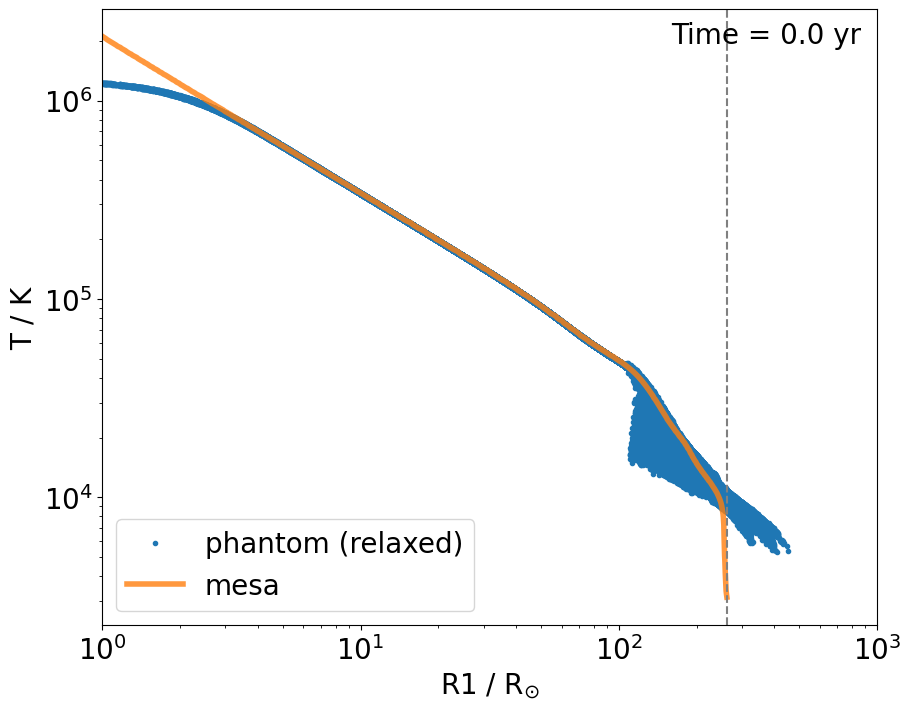

Saved to ../fig/20240222_LCGen/phantom-vs-mesa_2md_rho-R1.png


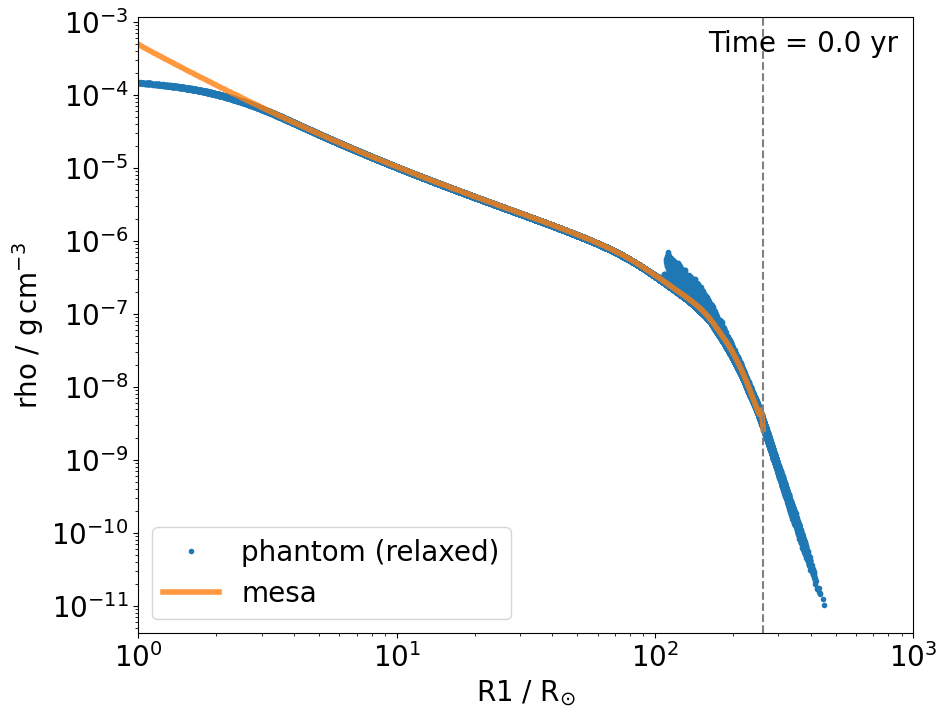

Saved to ../fig/20240222_LCGen/phantom-vs-mesa_2md_kappa-R1.png


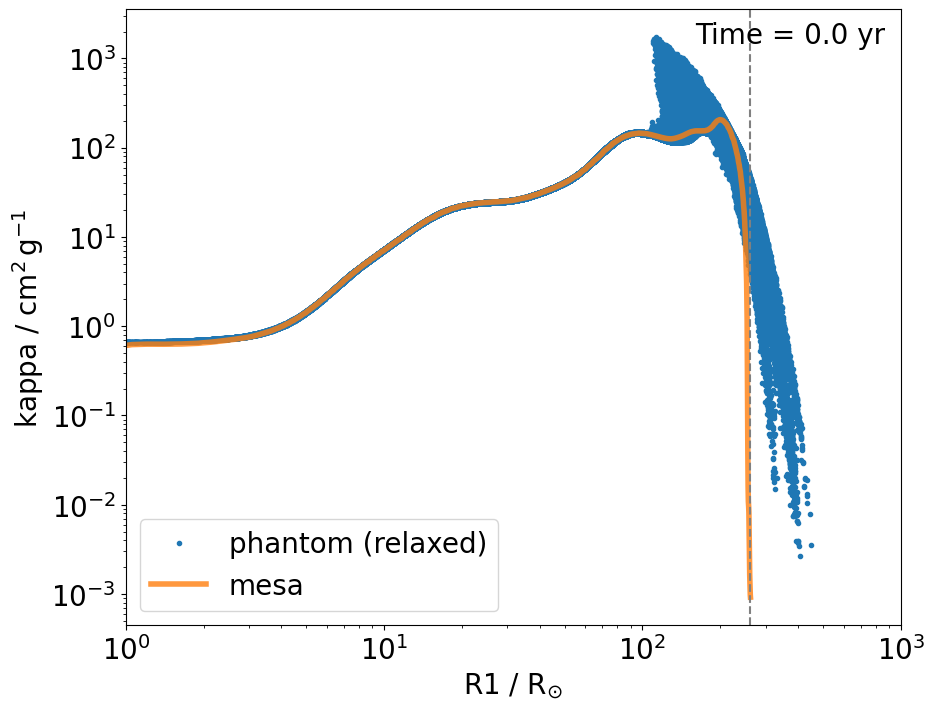

In [171]:
xlim = (1., 1e3)

plt.close('all')
for what in ['T', 'rho', 'kappa']:
    fig, ax, mask = plot_stuff(stuff, 'R1', what, mpdf, {'plot_title_suffix' : job_nickname + " - phantom vs mesa"}, xlim=xlim)
    
    xs, ys = stuff_mesa['R1'], stuff_mesa[what]
    if isinstance(xs, units.Quantity): xs = xs.value
    if isinstance(ys, units.Quantity): ys = ys.value
    if xlim is None: mask = np.ones_like(xs, dtype=np.bool_)
    else: mask = np.logical_and(xlim[0] < xs, xs < xlim[1])
    
    ax.loglog(xs[mask], ys[mask], '-', label='mesa', linewidth=4, alpha=0.8)
    
    ax.axvline(x=stuff_mesa['R1'][0].value, color='grey', linestyle='dashed')
    ax.legend(['phantom (relaxed)', 'mesa'], loc='lower left')
    outfilename_noext = f"{output_dir}phantom-vs-mesa_{job_nickname}_{what}-R1"
    fig.savefig(f"{outfilename_noext}.png")
    print(f"Saved to {outfilename_noext}.png")
    plt.show(fig)

In [162]:
stuff['R1']

<Quantity [117.41363041, 117.62030306,  39.48377157, ...,  79.99364505,
           214.41958202, 214.37990432] solRad>

### Timeit

In [ ]:
xyzs = 'yzx'
xyzs_names_list = [x for x in xyzs]
ans = integrate_along_ray_gridxy(sdf, srcfuncs, rays, xyzs_names_list=xyzs_names_list)
plt.close('all')
plt.imshow(ans.reshape(no_xy))
plt.savefig(f"{output_dir}/heat_I_{job_nickname}_{mpdf.file_index}_{xyzs}.png")
ans

In [ ]:
%timeit integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)

In [ ]:
%timeit integrate_along_ray_gridxy(sdf, srcfuncs, rays, verbose=0)

In [ ]:
%timeit [integrate_along_ray(sdf, ray, srcfuncs)[4] for ray in rays]

### Analyzing error for tau

In [ ]:
# integrating for column kernel
kernel = sdf.kernel
ndim   = 3
q_xy   = 1.
w_col  = kernel.get_column_kernel_func(1000)

q_xy   = 0.

@jit(nopython=True, fastmath=True)
def get_q(*q_is):
    ans = 0
    for q_i in q_is:
        ans += q_i**2
    return ans**0.5


def get_w_q(q_z, q_xy, w, ndim):
    return kernel.w(get_q(q_xy, q_z), ndim)

def my_col(q_xy:float, kernel, ndim:int = 3):
    w = kernel.w
    w_rad = kernel.get_radius()
    return integrate.quad(lambda q_z: w(get_q(q_xy, q_z), ndim), -w_rad, w_rad)
    
#my_col(q_xy, kernel=kernel, ndim=ndim),  w_col(q_xy, ndim)

In [ ]:


def get_tau_for_single_particle(kappa_m_div_h2:float, q_xy:float, kernel, ndim:int = 3):
    w = kernel.w
    w_rad = kernel.get_radius()
    w_col = kernel.get_column_kernel_func(1000)

    return -np.log(integrate.quad(
        lambda q_z: np.exp(-kappa_m_div_h2 * integrate.quad(
            lambda q_z1: w(get_q(q_xy, q_z1), ndim),
            -w_rad, q_z
        )[0]) * w(get_q(q_xy, q_z), ndim),
        -w_rad, w_rad, 
    )[0] / w_col(q_xy, ndim))

kappa_m_div_h2, q_xy = 100., 1.5
dtau  = kappa_m_div_h2*w_col(q_xy, ndim)
w_col = kernel.get_column_kernel_func(1000)
term = 1-np.exp(-dtau)
tau = get_tau_for_single_particle(kappa_m_div_h2=kappa_m_div_h2, q_xy=q_xy, kernel=kernel, ndim=ndim)
print(f"{tau=}", f"{dtau=}", f"frac= {(tau/dtau)*100:.2f}%", '', sep='\n')
print(
    f"{np.exp(-tau    )*term=}",
    f"{np.exp(-tau    )*dtau=}",
    f"{np.exp(-0.     )*term=}",
    f"{np.exp(-dtau/2.)*term=}",
    f"{np.exp(-dtau   )*term=}",
    sep='\n')

In [ ]:
w_col

In [ ]:
kappa_m_div_h2 * integrate.quad(
            lambda q_z1: w(get_q(q_xy, q_z1), ndim),
            -2., 1.)[0]

In [ ]:
help(kernel.get_column_kernel_func)

### In Writing

#### Getting LC

In [ ]:
do_extrap : bool = False
T_cond_oxy: units.Quantity = 1450 * units.K
kappa_gas : units.Quantity = 2e-4*(units.cm**2/units.g)
job_name    = '../dustystar/clmu_dustybase/relax'#job_profile['job_name']
file_index  = 0
params      = JOB_PROFILES_DICT['2md']['params'] #job_profile['params']


mpdf = mupl.MyPhantomDataFrames()
mpdf.read(job_name, file_index, reset_xyz_by='CoM', calc_params=['vr', 'R1'], verbose=verbose)
sdf  = mpdf.data['gas']
eos = mupl.get_eos(ieos=10, params=params, settings=settings)
eos_opacity = EoS_MESA_opacity(params, settings)
sdf['T'] = eos.get_temp(rho=mpdf.get_val('rho'), u=mpdf.get_val('u')).to_value(mpdf.units['temp'])
del sdf['Tdust']
kappa_mesa = eos_opacity.get_kappa(mpdf.get_val('rho'), mpdf.get_val('T'), do_extrap=do_extrap)
#mpdf.data['gas']['kappa'] = np.where(
#    mpdf.data['gas']['T'] < T_cond_oxy,
#    kappa_gas.to_value( mpdf.units['opacity']),
#    kappa_mesa.to_value(mpdf.units['opacity']),
#)
mpdf.data['gas']['kappa'] = kappa_mesa.to_value(mpdf.units['opacity'])

In [ ]:
# testing ray loc distribution
rays, areas, dXs = get_xy_grids_of_rays(sdf, no_xy=(32, 32), frac_contained=100., use_adaptive_grid=False)
plt.plot(rays[:, 0, 0], rays[:, 0, 1], '.')

In [ ]:
hs = dats
hs

In [ ]:
#no_xy=(17, 17)
no_xy=(32, 32)
srcfuncs = np.array(mpdf.const['sigma_sb'] * sdf['T']**4) / pi #/ (4 * pi)
#srcfuncs = np.array(sdf['h'])


rays, areas, _ = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False)
dats = integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)
lums = (4 * pi * dats * areas * mpdf.units['lum']).to(units.solLum)
lum  = lums.sum()
print(f"{lum:.2e}")
lum

In [ ]:
plt.hist(np.log10(mpdf.get_val('T').value))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.loglog(np.sqrt(rays[:, 0, 0]**2+rays[:, 0, 1]**2), lums.to_value(units.Lsun) / areas, '.')
ax.set_xlabel('$R_\\mathrm{CoM}$ / Rsun')
ax.set_ylabel('$I \\, / \\, (4 \pi L_\\odot / R_\\odot^2)$')
#ax.set_ylabel('$\\triangle L$ / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nbefore relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/scatter_dlum-vs-RCoM_relax_res{mpdf.params['nparttot']:.2e}.png")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=np.array(lums).reshape(no_xy))
fig.colorbar(s, label='')# {I / (4 \pi L_\\odot / R_\\odot^2)}$')
ax.set_xlabel('$x$ / Rsun')
ax.set_ylabel('$y$ / Rsun')
ax.set_title(f"Integrated  specfic intensity contribution per ray\nbefore relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_dlum_relax_res{mpdf.params['nparttot']:.2e}.png")

.

#### Trying the same thing with after-relaxed higher resolution model

.

In [ ]:
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
print(f"{mpdf.get_time() = }")

In [ ]:
mpdf.data['gas']['T'] = eos.get_temp(rho=mpdf.get_val('rho'), u=mpdf.get_val('u')).to_value(mpdf.units['temp'])
mpdf.data['gas'][['Tdust', 'temperature', 'T']]

In [ ]:
#no_xy=(17, 17)
no_xy=(32, 32)

srcfuncs = np.array(mpdf.const['sigma_sb'] * sdf['T']**4) / pi
rays, areas, _ = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False)
dats = integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)
lums = (4 * pi * dats * areas * mpdf.units['lum']).to(units.solLum)
lum  = lums.sum()
print(f"{lum:.2e}")
lum

In [ ]:
srcfuncs = np.array(sdf['h'])
rays, areas, _ = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False)
hs   = integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)
hs  *= units.Rsun
hs

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.loglog(np.sqrt(rays[:, 0, 0]**2+rays[:, 0, 1]**2), lums.value / areas, '.')
ax.set_xlabel('$R_\\mathrm{CoM}$ / Rsun')
ax.set_ylabel('$I \\, / \\, (4 \pi L_\\odot / R_\\odot^2)$')
ax.set_title(f"Integrated luminosity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/scatter_dlum-vs-RCoM_light_res{mpdf.params['nparttot']:.2e}.png")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(lums / areas).reshape(no_xy))) #np.log10
fig.colorbar(s, label='${I / (4 \pi L_\\odot / R_\\odot^2)}$') #\\log_{10} 
ax.set_xlabel('$x$ / Rsun')
ax.set_ylabel('$y$ / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_dI_light_res{mpdf.params['nparttot']:.2e}.png")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
#s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(lums / areas).reshape(no_xy))) #np.log10
s = ax.imshow(np.array(lums / areas).reshape(no_xy), origin='lower')
fig.colorbar(s, label='${I / (4 \pi L_\\odot / R_\\odot^2)}$') #\\log_{10} 
#ax.set_xlabel('$x$')# / Rsun')
#ax.set_ylabel('$y$')# / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_dI_light_res{mpdf.params['nparttot']:.2e}.png")

In [ ]:
plt.close('all')
fig, ax = plt.subplots(figsize=(10, 8))
#s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(lums / areas).reshape(no_xy))) #np.log10
s = ax.imshow(np.array(hs).reshape(no_xy), origin='lower')
fig.colorbar(s, label='$h \\, / \\, R_\\odot$') #\\log_{10} 
#ax.set_xlabel('$x$ / Rsun')
#ax.set_ylabel('$y$ / Lsun')
ax.set_title(f"Integrated smoothing length per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_h_light_res{mpdf.params['nparttot']:.2e}.png")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(hs).reshape(no_xy))) #np.log10
fig.colorbar(s, label='${h / R_\\odot}$') #\\log_{10} 
ax.set_xlabel('$x$ / Rsun')
ax.set_ylabel('$y$ / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_h_light_res{mpdf.params['nparttot']:.2e}.png")

In [ ]:
help(ax.imshow)

In [ ]:
7534.8/10246.54

In [ ]:
f"{lum:.2e}"

In [ ]:
get_xy_grids_of_rays

In [ ]:
plt.imshow(np.array(lums).reshape(no_xy))

In [ ]:
np.max(mpdf.data['gas']['h'])

In [ ]:
mpdf.data['gas']['u']

## IGNORE BELOW
#### NOT YET FINISHED ADAPTING FROM THE OLD SCRIPTS

### Other

In [ ]:
np.log(678e89)

In [ ]:
%timeit np.log(123e34) - 211.44922056441047

In [ ]:
%timeit 123e34 / np.exp(211.44922056441047)

In [ ]:
(450*units.au).to_value(mpdf.units['dist'])

In [ ]:
inds = (sdf['R1'] > (450*units.au).to_value(mpdf.units['dist']))
(np.sum(sdf[inds]['m'])*mpdf.units['mass']).to(units.Msun)

In [ ]:
# Test
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
inds = (sdf['R1'] > (450*units.au).to_value(mpdf.units['dist']))
(np.sum(sdf[inds]['m'])*mpdf.units['mass']).to(units.Msun)

In [ ]:
mpdf.get_val('kappa').cgs

In [ ]:
stuff = {}
stuff['kappa'] = mpdf.get_val('kappa').cgs
stuff['R1'   ] = mpdf.get_val('R1').to(units.Rsun)
stuff['T'    ] = mpdf.get_val('T').to(units.K)
stuff['L'    ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T']**4)).to(units.Lsun)
stuff['wtf'  ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T'].value**2.5 * units.K**4)).to(units.Lsun)
stuff['rhokappa'] = mpdf.get_val('rho').cgs * mpdf.get_val('kappa').cgs
stuff['rhokappaR'] = mpdf.get_val('rho').cgs * mpdf.get_val('kappa').cgs * mpdf.get_val('R1').cgs

In [ ]:
np.max(stuff['rhokappaR'] / (stuff['rhokappaR'] - 2) - 1)

In [ ]:
np.min(stuff['rhokappaR'] )

In [ ]:
(stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs

In [ ]:
(L_0 / R_0**2).cgs

In [ ]:
plt.plot(stuff_mesa['R1'], stuff_mesa['factor'])
plt.ylim(0., 2.)

In [ ]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'factor', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'wtf', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'lum', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
stuff_mesa['T']

In [ ]:
eos_opacity.get_kappa(stuff_mesa)

In [ ]:
stuff_mesa['lum'][:10]

In [ ]:
stuff_mesa['L'][0], stuff_mesa['lum'][0]

In [ ]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'T', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'L', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
stuff_mesa['R1'][::100]

In [ ]:
# phantom plots

In [ ]:
fig, ax = plot_stuff(stuff, 'R1', 'rhokappa', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
fig, ax = plot_stuff(stuff, 'R1', 'kappa', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
fig, ax = plot_stuff(stuff, 'R1', 'T', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
fig, ax = plot_stuff(stuff, 'R1', 'L', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
mpdf.plot_render()

In [ ]:
rays, areas = get_xy_grids_of_rays(sdf, no_xy=(17, 17), frac_contained=99.99)
rays

In [ ]:
no_xy=(17, 17)
rays, areas = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=99.99)
lums = []
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lums.append(dat * area) #* 4 * pi 
    if len(lums)%10 == 0:
        print(len(lums))

lums = (lums * mpdf.units['lum']).to(units.solLum)
lum = lums.sum()
lum

In [ ]:
# Test
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity)
sdf  = mpdf.data['gas']
ray = mupl.get_rays(mpdf.data['sink'][['x', 'y', 'z']].iloc[0], np.array([0., 0., 1.]))
srcfuncs = mpdf.const['sigma_sb'] * sdf['T'] * sdf['T']**4 #/ (4 * pi)

In [ ]:
rays, areas = get_xy_grids_of_rays(sdf, no_xy=(17, 17))
lum = 0.
lums = []
i = 0
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lum += dat * area #* 4 * pi
    lums.append(dat*area)
    if i%50 == 0:
        print(i)
    i += 1

lum *= mpdf.units['lum']
lum.to(units.solLum)/1e6

In [ ]:
sdf['R0'] = (sdf['x']**2 + sdf['y']**2 + sdf['z']**2)**0.5
sdf['kappa_cgs'] = mupl.units_util.get_val_in_unit(sdf['kappa'], mpdf.units['opacity'], units.cm**2/units.g)
sdf.iloc[np.array(sdf['R0'] > 380)]

In [ ]:
mpdf.plot_render()

In [ ]:
rays, areas = get_xy_grids_of_rays(sdf, no_xy=(16, 16))
lum = 0.
i = 0
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lum += dat * area #* 4 * pi 
    if i%50 == 0:
        print(i)
    i += 1

lum *= mpdf.units['lum']
lum.to(units.solLum)

In [ ]:
ans = integrate_along_ray(sdf, ray, srcfuncs)
pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
dat

In [ ]:

np.where(dat_bwd_inc / dat > 1e-7), dat_bwd_inc.shape

In [ ]:
def get_ph_vals(
    vals_names: list,
    mpdf: MyPhantomDataFrames,
    eos: mupl.eos_base.EoS_Base,
    rays_unit_vecs : np.ndarray, # (no_ray, 3)-shaped
    verbose: int,
):
    sdf_all = mpdf.data['gas']
    hs = np.array(sdf_all['h'])
    pts = np.array(sdf_all[['x', 'y', 'z']])    # (npart, 3)-shaped array
    kernel_radius = sdf_all.kernel.get_radius()

    plane_orig_vec = np.array(mpdf.data['sink'][['x', 'y', 'z']].iloc[0])

    # random direction in the sphere
    #rays_unit_vecs = get_rand_rays_unit_vec(no_ray)
    no_ray = len(rays_unit_vecs)
    
    vals_dict = {
        'tau_dust': np.full(no_ray, np.nan),
        'inner_dust_shell_rad': np.full(no_ray, np.nan) * mpdf.units['dist'],
    }
    
    for iray, ray_unit_vec in enumerate(rays_unit_vecs):
        ray = np.array([
            plane_orig_vec,
            plane_orig_vec + ray_unit_vec,
        ])
        
        pts_on_ray = mupl.get_closest_pt_on_line(pts, ray)
        sdf_selected_indices = (np.sum((pts - pts_on_ray)**2, axis=-1) <= (kernel_radius * hs)**2)
        sdf = sdf_all.iloc[sdf_selected_indices]
        
        pts_on_ray, dtaus, pts_order = get_optical_depth_by_ray_tracing_3D(sdf, ray)
        photosphere, waypts_list = get_photosphere_on_ray(
            pts_on_ray, dtaus, pts_order, sdf, ray,
            calc_params = vals_names,
            eos = eos,
            sdf_units = mpdf.units,
            photosphere_tau = PHOTOSPHERE_TAU,
            return_as_quantity=True,
            verbose = 1 if is_verbose(verbose, 'err') else 0,
        )
        for val_name in vals_names:
            if iray == 0:
                # init
                vals_dict[val_name] = np.full((*photosphere[val_name].shape, no_ray), np.nan)
                if isinstance(photosphere[val_name], units.quantity.Quantity):
                    vals_dict[val_name] *= photosphere[val_name].unit
            # save value
            vals_dict[val_name][iray] = photosphere[val_name]
            
            kappa_tol = 1e-7*(units.cm**2/units.g)
            kappa_tol_val = kappa_tol.to_value(mpdf.units['opacity'])
            pts_waypts_t = np.sum((pts_on_ray - ray[0]) * ray_unit_vec, axis=-1) # the higher, the more on the pt2 side (observer)
            # find the furtherest dust-containing particle on the observer's side
            last_dust_part_ordered_indices = np.where(np.logical_and(
                pts_waypts_t[pts_order] > 0,    # condition 1: on the observer's side (i.e. don't be further than the sink)
                sdf.iloc[pts_order]['kappa_dust'] > kappa_tol_val,    # condition 2: dust-containing
            ))[0]
            if len(last_dust_part_ordered_indices):
                # found the dust shell!
                last_dust_part_ordered_ind = last_dust_part_ordered_indices[-1]
                vals_dict['tau_dust'][iray] = np.sum(dtaus[pts_order][:last_dust_part_ordered_ind])
                vals_dict['inner_dust_shell_rad'][iray] = mupl.set_as_quantity(
                    pts_waypts_t[pts_order][last_dust_part_ordered_ind], mpdf.units['dist'])
    vals_dict['cos_theta'] = rays_unit_vecs[:, 2]
    vals_dict['ray_unit_vec'] = rays_unit_vecs
    
    return vals_dict

In [ ]:
def get_photosphere_vals_rand_samples(
    job_nickname: str,
    file_index: int,
    no_ray: int,
    vals_names: list = ['R1', 'T'],
    cos_theta_sample_no: int|None = None,
    mpdf: MyPhantomDataFrames = None,
    verbose: int = 3,
) -> dict:
    
    job_profile = JOB_PROFILES_DICT[job_nickname]
    job_name    = job_profile['job_name']
    params      = job_profile['params']
    ieos = job_profile['ieos']
    eos  = get_eos(ieos, params, settings)
    eos_opacity = EoS_MESA_opacity(params, settings)
    
    mpdf = mpdf_read(
        job_name, file_index, eos_opacity, mpdf,
        kappa_gas = 2e-4*(units.cm**2/units.g) if file_index != 0 else 0.*(units.cm**2/units.g),
        verbose=verbose)

    if cos_theta_sample_no is None:

        rays_unit_vecs = get_rand_rays_unit_vec(no_ray)
        vals_dict = get_ph_vals(vals_names, mpdf, eos, rays_unit_vecs, verbose=verbose)
    
        if is_verbose(verbose, 'note'):
            say('note', f'{mpdf.get_filename()}', verbose,
                *[f'{val_name} = {np.average(vals_dict[val_name])} +/- {np.std(vals_dict[val_name])}' for val_name in vals_names]
            )
    else:
        # A fixed amount of rays per cos_theta interval will be generated
        #cos_theta_sample_no = 2
        ray_per_cos_theta = int(no_ray/cos_theta_sample_no)
        cos_theta_delta = 1. / cos_theta_sample_no
        cos_thetas = np.linspace(-1+cos_theta_delta, 1-cos_theta_delta, cos_theta_sample_no)
        vals_by_cos_thetas = []
    
        for i, cos_theta_mid in enumerate(cos_thetas):
            rays_unit_vecs = get_rand_rays_unit_vec(ray_per_cos_theta, cos_theta_mid, cos_theta_delta)
            vals_dict = get_ph_vals(vals_names, mpdf, eos, rays_unit_vecs, verbose=verbose)
            #vals_dict['cos_theta'] = rays_unit_vecs[:, 2]
            vals_by_cos_thetas.append(vals_dict)
        
            if is_verbose(verbose, 'note'):
                say('note', f'cos_theta_mid = {cos_theta_mid}', verbose,
                    *[f'{val_name} = {np.average(vals_dict[val_name])} +/- {np.std(vals_dict[val_name])}' for val_name in vals_names]
                )
        
        vals_dict = { key: np.concatenate([data[key] for data in vals_by_cos_thetas]) for key in vals_by_cos_thetas[0].keys()}

    return vals_dict

.

## Main

.


In [ ]:
if __name__ == '__main__':
    mpdf = MyPhantomDataFrames()
    for job_nickname in ['2md']:  # '2md', 
        for file_index in [4800, 6400]: # [0, 2000, 8000, 17600]
            vals_dict = get_photosphere_vals_rand_samples(
                job_nickname, file_index, no_ray, vals_names=['R1', 'T', 'rho', 'kappa', 'nneigh', 'vr'], cos_theta_sample_no=None, mpdf=mpdf)
            with open(f"{mpdf.get_filename()}__photosphere-vals.json", 'w') as f:
                json_dump(vals_dict, f, metadata)
    if is_verbose(verbose, 'note'):
        say('note', '__main__', verbose, f"\n\n\n*** All Done. ***\n\n\n")